# <span style="color:Tomato"> **Prueba 1**: Extraer la polaridad de sentimiento asociado a un texto. </span>

## 1- Hito 1

### 1.1 - Preliminares

#### 1.1.1 - Entendimiento del problema

##### 1.1.1.a - Problematica

Hoy en día el uso de RRSS ya es para todo rango de edades, las interacciones diarias con comentarios, articulos, posteos, notas, etc... son mas comunes que periodico que se solía leer. El cual posee toda una linea editorial, donde se controla el contenido impreso segun los emisores (lo cual nos podria llevar a otras problematicas).

Frente a este escenario de lo instantaneo que son las RRSS y las interacciones presentes en la mayor parte del internet, es que con el tiempo se han desarrollado cada vez mas y mejores herramientas para automatizar el proceso de filtrado de contenido (quiza estemos entrando en la misma problematica de los periodicos y sus editoriales). A modo de ejemplo, hoy en día instagram es capaz de forma instantanea y automatizada de detectar el sentimiento de un posteo al momento de presionar el boton enviar, lanzando una ventana emergente advirtiendo al usuario una infraccion a las normas comunitarias.

Es aquí donde se entra al tema a tratar:
* Análisis de sentimiento (o minería de opínion): Es el uso de procesamiento de lenguaje natural, análisis de texto y linguistica computacional para identificar y extraer informacion subjetiva de los recursos, en este caso sera en base a los datos proporcionados por CroedFlower en su base de datos 'training_tweets.csv'
* El analisis de sentimiento corresponde a una tarea de **clasificación** en funcion a la connotacion **positiva o negativa**. 
* Notar que se basa en relaciones estadistica y de asociación y no en el análisis linguistico, por lo que habran factores que mirar con mucho cuidado, dado su origen no formal y gramatica, o el uso de jergas linguisticas.

##### 1.1.1.b - Atributos

* Content: Muestra el contenido del tweet para cada entrada.
    - Con el pre-procesamiento de datos se genera una matriz a considerar como el vector de atributos 'X' el cual en el modelo debe tener la misma candidad de filas que el vector 'y' asociado a los sentimientos positivos o negativos.
    - Luego por motivos computacionales y para evitar caer en la maldicion de la dimenesionalidad (si es que fuese el caso) se aplicara una reduccion de dimensiones, y asi se evita el exceso de recursos computacionales y elimina dimensiones redundantes de la matriz 'X'. 

##### 1.1.1.c - Vector Objetivo

* Sentiment: Se trata del sentimiento asociado del tweet, si bien en su forma original representa mas de dos sentimientos, este sera recodificado para que tome caracter binario. 
* Recodificacion a realizar:
    - 'worry' :'Negativa'
    - 'happiness' :'Positiva'
    - 'sadness' :'Negativa'
    - 'love' :'Positiva'
    - 'surprise' :'Positiva'
    - 'fun' :'Positiva'
    - 'relief' :'Positiva'
    - 'hate' :'Negativa'
    - 'empty' :'Negativa'
    - 'enthusiasm' :'Positiva'
    - 'boredom' :'Negativa'
    - 'anger':'Negativa'
    - Neutros se codifican de forma aleatoria

##### 1.1.1.d - Tipo de problema

* Dada la recodificacion a realizar de caracteristicas binarias, en positivas y negativas, sabemos que nuestro problema sera un problema de **clasificacion**.
* Dicho esto, mencionar que el objetivo sera lograr un modelo capaz de decir si el sentimiento asociado al tweet es positivo o negativo.
* A modo de estudio complementario se va a considerar un 3 valor para el vector objetivo, el cua corresponderia a la categoria neutral.

#### 1.1.2 - Aspectos Computacionales

##### 1.1.2.a - Librerías
* Python 3.9.16
* conda 23.3.1
* pandas 1.5.3
* numpy 1.24.3
* matplotlib 3.7.1
* matplotlib-inline 0.1.6
* regex 2022.7.9
* nltx 3.7
* scikit-learn-intelex (daal4py) 2023.0.2

In [1]:
#Ignorar alertas de deprecacion
import warnings
warnings.filterwarnings("ignore")
#Manejo de base de datos y funciones estadisticas
import pandas as pd
import numpy as np
#Generar graficas y estilos de graficos.
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# gestion de palabras
import re #unicode strings
import nltk # palabras
from nltk.stem import WordNetLemmatizer # lematizacion
from nltk.corpus import stopwords #stopwords
#Preprocesamiento
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # conteo de palabras



from sklearn.decomposition import PCA # reduccion de dimensiones

#Dividir matriz de datos
from sklearn.model_selection import train_test_split 

#Grillas de crossvalidation
from sklearn.model_selection import GridSearchCV

#Modelos
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier


#Metricas
from sklearn.metrics import classification_report

#Seralizacion
from pickle import dump

##### 1.1.2.b - Funciones propias

In [1]:
from funciones_p1 import df_palabras_frecuencia #analisis de palabras con CV.
from funciones_p1 import word_count_by_clasif #graficar frec por classification.
from funciones_p1 import plot_classification_report as pcr #graficar reporte de metricas
from funciones_p1 import graficar_porcentajes_cat #graficar porcentajes
from funciones_p1 import detalle_freq1 #info de palabras con freq 1
from funciones_p1 import modelacion_inicial #Modela e imprime reprotes
from funciones_p1 import prueba_tweets #Testea modelo con tweets
from funciones_p1 import prueba_tweets_nb  #Testea modelo con tweets sin PCA

#### 1.1.3 - Modelos y grillas a implementar

##### 1.1.3.a - Metodología

En los ejercicios de analisis de sentimientos es fundamental el trabajo con los datos, por lo cual se ejecutaran los siguientes pasos previos a la modelacion.

1. Definir el algoritmo que utiliza el metodo CountVectorizer de scikit-learn con el fin de disminuir las dimensiones y palabras no deseadas en nuestra transformacion vectorial.
    - Se definenen algoritmos distintos para probar con un modelo de prueba.
2. Una vez limpios los datos de estudio, se realiza disminucion de dimensionalidad mediante Principal Component Analysis (PCA).
3. Generar 5 modelos y seleccionar 3 de ellos para la busqueda de hiper parametros.
    - Linear Discriminant Analysis LDA
    - Super vector machine
    - DecisionTreeClassifier y Random Forest Classification
    - AdaBoostClasifier y GradientBoostingClassifier 
    - Voting Classifier


##### 1.1.3.b - Informacion adicional:

*  Pang​ mostró que eliminar las oraciones objetivas de un documento antes de clasificar su polaridad ayudó a mejorar su rendimiento.
* Varios investigadores sugieren que, al igual que en todo problema de polaridad, tres categorías deben ser identificadas. Algunos clasificadores específicos tales como el de Máxima Entropía​ y las SVMs​ se pueden beneficiar de la introducción de la clase neutra y mejorar la precisión global de la clasificación

#### 1.1.4 - Modelos y Grillas

##### 1.1.4.a - Linear Discriminant Analysis

* Linear Discriminant Analysis LDA: Modelo utilizado para la disminucion de dimensiones y clasificacion de datos. Busca combinaciones lineales para encontrar la mejor forma de separar las categorias. Dicho esto se utilizara una clasificacion binaria modificando los hiperparametros disponibles.
* Parametros para la grilla:
    - solver = 'svd' , lsqr
    - shrinkage = 'none' : reduce la varianza de las estimaciones de las covarianzas de las clases.
    - priors = valor se infiere desde la data
    - n_components = none implica el minimo: numero de componentes a extraer.

##### 1.1.4.b - Super Vector Machine (SVM: SVC en sklearn)

* Super Vector Machine (SVM: SVC en sklearn): Algoritmo de aprendizaje supervisado. Construye un hiperplano en un espacio de alta dimension y busca maximizar la distancia entre los puntos del hiperplano. Permite encontrar el hiperplano optimo incluso cuando los datos no son linealmente separables.
    - Capacidad de manejar conjuntos de datos de alta dimensionalidad y complejos.
    - Alto consumo computacional.
    - Variantes de menor consumo computacional LinearSVC y SGDClassifier.
* Parametros para la grilla
    - C : [float] default=1.0 = parametro de regularizacion
    - kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
    - degree: int, default=3 : grado del polinomio del kernel 
    - gamma: {‘scale’, ‘auto’} or float, default=’scale’: Coeficiente del kernel
    - random_state


##### 1.1.4.c - Random Forest Classification

* Es un algoritmo de aprendizaje supervisado. En vez de construir solo un arbol de decision como en decision tree clasifier, genera muchos y promedia los resultados.
    - Selecciona aleatoriamente submuestras de X e Y para evitar sobre ajuste y mejorar la capacidad de generalización.
    - Genera una medida de importancia en cada caracteristica.
* Parametros:
    - n_estimators: default=100
    - criterion: “gini”, “entropy”, “log_loss”, default=”gini”
    - max_depth: profundidad default: none = nodos expandidos hasta que las hojas contengan min_samples_split samples o puras
    - min_samples_split: default=2 : minimo numero de samples para separar un nodo, un valor mayor puede reducir el riesgo de sobreajuste
    - min_samples_leaf: default=1 : este parámetro controla el número mínimo de muestras que se requieren en cada hoja del árbol. Un valor mayor puede hacer que el modelo sea más generalizado
    - max_features{“sqrt”, “log2”, None}, int or float, default=”sqrt”
    - warm_start: default=False: True = Reutiliza la solucion previa para entrenar y agregar mas estimadores.
    - random_state

##### 1.1.4.d - AdaBoost o Adaptive Boosting y Gradient Boost

* Ada boost: Algoritmo de aprendizaje automatico supervisado, utilizado para mejorar la precision de modelos de aprendizaje debil. Corrije dandole peso a los puntos donde el modelo anterior clasificó de manera incorrecta.
    - comunmente utiliza como modelos debiles arboles de decision, regresion logistica o SVM
    - Util para modelos de clasificacion binaria, multiclase, imagenes, deteccion de spam.
* Parametros
    - Estimator: default: DecisionTreeClassifier
    - n_estimators: default: 50 = Numero de clasificadors debiles utilizados en el modelo, a medida que aumenta el modelo se vuelve mas preciso, pero tambien aumenta el tiempo de entrenamiento.
    - Learning rate: default:1.0 = controla la contribución de cada estimador en el conjunto final. Un learning rate alto significa que se da más importancia a la contribución de cada estimador individual, lo que puede llevar a un sobreajuste. Un learning rate bajo significa que cada estimador individual contribuye poco al modelo final, lo que puede llevar a un bajo rendimiento.
    - randomstate

* Gradient boosting: Es similar en su funcionamiento a adaboost. A diferencia de Adaboost, GBC construye árboles secuencialmente y cada nuevo árbol se entrena para corregir los errores del modelo anterior. De esta manera, cada árbol se enfoca en corregir los errores de los árboles anteriores
* Parametros:
    - loss: ‘log_loss’, ‘deviance’, ‘exponential’, default=’log_loss’= Funcion de perdida a ser optimizada en exponencial  gradient boost toma el algoritmo de adaboost
    - n_estimator: default 100 = un numero alto siele resultar en una mejor performance.
    - subsample: default=1 = fraccion de muestras para ser entrenadas como base del aprendizaje. seleccionar un valor menor a 1 implica reduccion de la varianza debe estar entre 0 y 1
    - min_samples_split: default 2 = min de muestras requeridas para dividir un nodo. Un valor más alto evita divisiones que conducen a regiones con pocas muestras, lo que puede reducir el sobreajuste, pero también puede hacer que el modelo pierda información importante.
    - min_samples_leaf: default 1 = min de muestras requeridas para estar en un nodo de hoja.
    - max_depthi: int - None, default:3 =  La profundidad máxima de cada árbol. Un valor más alto permite que el modelo capture relaciones más complejas, pero también aumenta la posibilidad de sobreajuste.
    - max_features{‘auto’, ‘sqrt’, ‘log2’}, int or float, default=None
    - warm_star: tbool, default: False = Guarda el resultado anterior en la memoria para iterar.
    - randomstate
    

##### 1.1.4.e - Voting Classifier

* Algoritmo de ensamble que combina multiples modelos de aprendizaje automatico para producir su prediccion.
* parametros:
    - Estimators: una lista de estimadores a utilizar. Cada estimador debe ser un objeto de clasificación o regresión que tenga los métodos fit y predict.
    - Voting: default: hard = Tipo de votación a utilizar. Puede ser 'hard' (predicciones discretas) o 'soft' (predicciones de probabilidad).
    - weights: una lista de pesos que se aplican a cada estimador. Los pesos pueden utilizarse para ajustar la importancia de cada estimador en la votación final.
    - flatten_transform: un parámetro booleano que indica si se deben aplanar los resultados de la transformación predictiva. Si se establece en True, los resultados se aplanan en una matriz unidimensional.


### 1.2 Análisis Exploratorio

#### 1.2.1 Estudio del vector objetivo

##### 1.2.1.a - Importar dataframe

In [3]:
df = pd.read_csv('training_tweets.csv')
df

,Unnamed: 0,content,sentiment
0,34723,Happy Mama's day to all mothers,love
1,17493,@LysdelTellez I am lost. Please help me find a...,worry
2,20198,"@BoomKatt yes yes I AM, networking whore to th...",happiness
3,6855,you@snapplynn Wish that would have been your t...,neutral
4,5924,now i am doing the MicroEconomics project iha...,worry
...,...,...,...
29995,16469,I do not want to work tomorrow!,sadness
29996,36006,@KandyBee we shuld do a dance like that its s...,fun
29997,22647,"Photo: Got my prints a few days ago, ready for...",happiness
29998,21478,@tove_liden Thanks for the follow Tove!,fun


In [4]:
# Visto lo anterior se descarta la columna 'Unnamed: 0'
df = df.drop(columns='Unnamed: 0')

##### 1.2.1.b - Grafico del vector objetivo **sentiment** sin recodificar

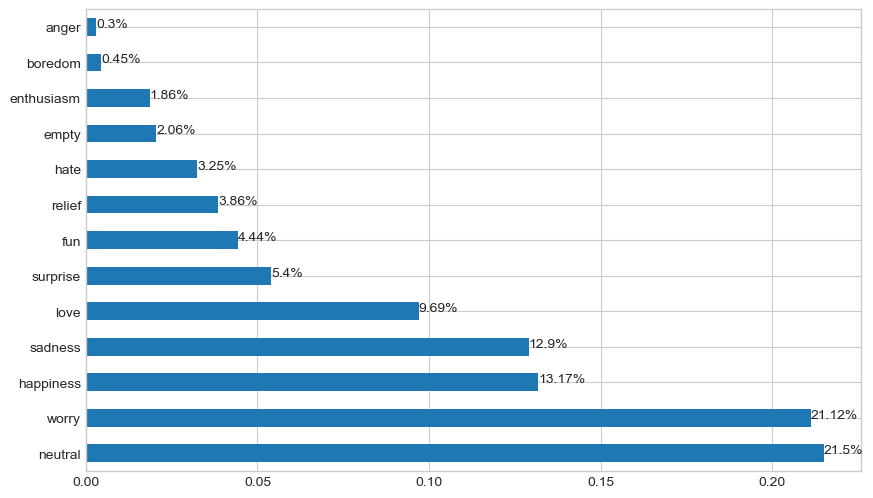

In [5]:
graficar_porcentajes_cat(df['sentiment'])

* Se observa una gran cantidad de sentimientos neutrales 21,5%, seguido por worry 21.12%. luego los siguen happiness y sadnes. de los que menos encontramos son anger y boredom ambos con frecuencias menores a 1.
* Lo mas critico del vector objetivo parece ser la gran concentracion de valores neutrales, mas adelante evaluaremos la forma agrupada de los sentimientos, luego de hacer la recodificacion.

#### 1.2.2 Estudio de datos nulos

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    30000 non-null  object
 1   sentiment  30000 non-null  object
dtypes: object(2)
memory usage: 468.9+ KB


No se observan datos perdidos en la dataframe original.

#### 1.2.3 Recodificación del vector objetivo

##### 1.2.3.a - Recodificacion propuesta por el ejercicio.

* Categoria neutral codificada en positiva o negativa con un 50% de probabilidad.
* Se incluye una semilla aleatoria para que no varien los resultados con cada ejecucion del notebook

In [7]:
np.random.seed(1991)
emociones = {
'worry' :'Negativa',
'happiness' :'Positiva',
'sadness' :'Negativa',
'love' :'Positiva',
'surprise' :'Positiva',
'fun' :'Positiva',
'relief' :'Positiva',
'hate' :'Negativa',
'empty' :'Negativa',
'enthusiasm' :'Positiva',
'boredom' :'Negativa',
'anger':'Negativa',
'neutral': np.random.choice(['Positiva', 'Negativa'])
}

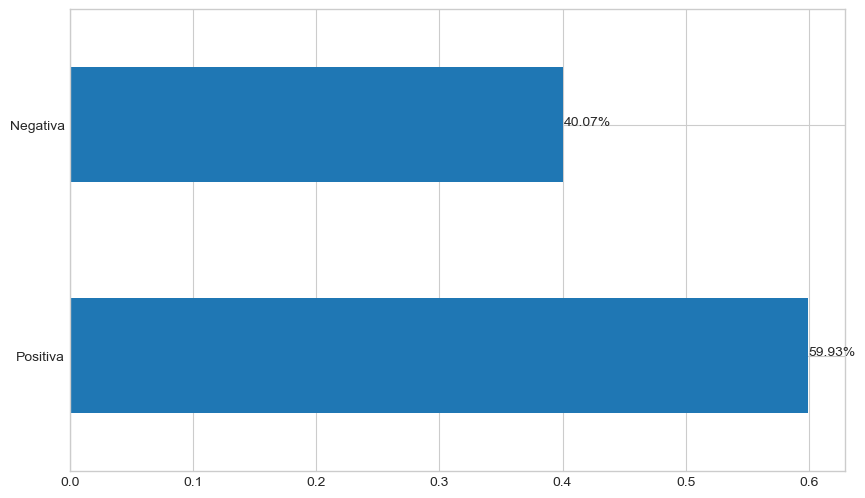

In [8]:
df['emociones'] = df['sentiment'].replace(emociones)
graficar_porcentajes_cat(df['emociones'])

* Luego del a recodificacion se observan categorias balanceadas entre 40 y 60 %

##### 1.2.3.b - Recodificacion alternativa propuesta.

Se mantendra la categoria Neutral, dado que segun estudios los modelos de clasificacion de sentiminetos se ven favorecidos por tener una categoria neutral.

Ademas como se muestra en el gráfico de la seccion  1.2.1.b la categoria neutral en comparacion a los otros sentimientos sin recodificar, ocupa la mayor frecuencia dentro del dataframe 21.5%, por lo que clasificar los tweets de manera aleatoria seria dejar aproximadamente un quinto de de los datos de entrenamiento a un ejemplo aleatorio, siendo que si los categorizamos de forma independiente nos proporcionara mas informacion que no hacerlo.

In [9]:
emociones_neu = {
'worry' :'Negativa',
'happiness' :'Positiva',
'sadness' :'Negativa',
'love' :'Positiva',
'surprise' :'Positiva',
'fun' :'Positiva',
'relief' :'Positiva',
'hate' :'Negativa',
'empty' :'Negativa',
'enthusiasm' :'Positiva',
'boredom' :'Negativa',
'anger':'Negativa'
}


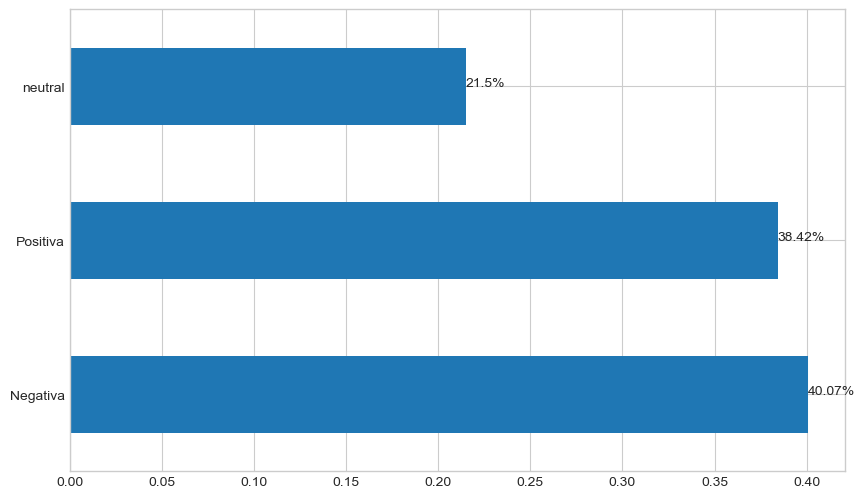

In [10]:
df['emociones_neu'] = df['sentiment'].replace(emociones_neu)
graficar_porcentajes_cat(df['emociones_neu'])

* En comparacion al grafico anterior, notar que la brecha entre positivos y negativos disminuye considerablemente.
* Los neutrales muestran ser un 21% de los datos, menor a todas las categorias.
* Un dataframe balanceado serian todos los valores cercanos al 33%, si bien esta muestra no esta desbalanceada al extremo la mayor concentracion de datos se encuentra entre los positivos y negativos.

#### 1.2.4 - Busquedas de grilla propuestas

* Grilla modelo LDA:
    - 'solver': ['svd', 'lsqr', 'eigen']
    - 'priors': [[.35,.65],[.4,.6],[.45,.55],[.55,.45],[.6,.4],[.65,.35]]
* Grilla modelo SVC:
    - 'C' : [1,100]
    - 'gamma': [10, 100]
    - 'kernel': ['rbf']
* Grilla modelo Random Forest:
    - 'max_depth':[100,None]
    - 'criterion':['gini','entropy']
    - 'min_samples_split':[0.001,0.1]
    - 'min_samples_leaf':[0.0000001,0.001]
* Grilla modelo Gradient Boost
    - 'learning_rate': [0.0001,0.01,1]
    - 'max_depth':[1, 10,100]
    - 'subsample': [.1,.3,.4]
* Ponderacion para modelos Voting respectivamente {voting categoria 0, voting balanceado, gradient boosting}:
    - w1 = [.3, .2, .5 ]
    - w2 = [.2, .2, .6 ]

## Hito 2

### 2.1 Feature Engineering

#### 2.1.1 Ingeniería de atributos


Se estudian distintas formas de trabajar con CountVectorizer a modo limpiar las palabras de los tweets, para obtener nuestras matriz 'X' de parametros.

Mencionar que se consideran los siguientes parametros de CountVectorizer en sus valores por defecto, entre ellos algunos que son relevante para el ejercicio, ademas se trabaja con una funcion tokenizadora que remplaza algunos de estos parametros:

* **lowercasebool** = True : Todo en minuscula
* **token_pattern** = r”(?u)\b\w\w+\b” :
    - (?u): Caracteres pertenecen a Unicode
    - \b: Limitado por caracteres que no sean alfanuméricos, es decir, que no formen parte de una palabra.
    - \w\w+: Debe estar conformado por al menos dos caracteres alfanuméricos, siendo el primer caracter cualquier letra o número (\w), y los siguientes caracteres, si es que existen, también alfanuméricos (\w+).
* **min_df** = 1 : Frecuencia minima admitida en matriz respuesta.
* **analyzer** = default=’word’ : tokenizadores {‘word’, ‘char’, ‘char_wb’} or callable, 

##### 2.1.1.a Metodo 1: **Stop words**

Evaluar solo utilizando stopwords, los cuales corresponden a palabras que por si solas no poseen mayor significancia.

In [11]:
# descargar lista de stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stops = set(stopwords.words('english'))
print(stops)
stops = list(stops)

{"it's", 'too', 'shouldn', 'not', 'to', 'are', "you've", 'him', 'her', 'off', 'wouldn', 'further', 'itself', 'under', 'be', 'with', 'doesn', "that'll", 'and', 'an', 'as', 'wasn', 'that', 'have', 'themselves', 'doing', 'didn', 'ain', 'it', "won't", 'no', 'some', 'out', 'does', 'how', 'don', "should've", "you'd", 'which', 'or', 'weren', 'we', 'has', 't', "isn't", "doesn't", 'hers', 'such', 'hadn', "you'll", 'had', 'once', 'then', 'there', "wouldn't", 'both', 'd', 'having', 'for', 'down', 'they', 'about', "mightn't", 'on', 'm', 'below', 'where', 'but', 'needn', 'just', 'couldn', 'this', 'o', 'did', 'haven', 'yours', 'very', 'she', "weren't", 'yourself', 'before', 'my', 'shan', "don't", 'their', "didn't", 'y', 'until', 'here', 'was', 'ourselves', 'me', 'between', 'himself', 'while', 'herself', 'in', 'those', 'these', 're', 'if', 'all', 'our', 'again', 'your', 'up', 'll', 'at', 'through', 'should', 'from', "shouldn't", 'than', 'other', "she's", 'being', 'isn', 'them', 'each', 'nor', "needn'

In [13]:
#Entrenar y transformar CV con los tweets.
cv_a = CountVectorizer(stop_words=stops)
cv_a_fit = cv_a.fit_transform(df['content'])

* En esta primera iteracion se explica el metodo utilizado:
    - cv_a: metodo CountVectorizer para aplicar en los datos, luego del fit se encuentra entrenado con los datos. Al aplicar fit transform ademas de aprender de los datos los transforma, resultando en cv_a_fit nuestra matriz completa de atributos X

In [14]:
cv_a

CountVectorizer(stop_words=["it's", 'too', 'shouldn', 'not', 'to', 'are',
                            "you've", 'him', 'her', 'off', 'wouldn', 'further',
                            'itself', 'under', 'be', 'with', 'doesn', "that'll",
                            'and', 'an', 'as', 'wasn', 'that', 'have',
                            'themselves', 'doing', 'didn', 'ain', 'it', "won't", ...])

In [15]:
# Matriz de atributos X
cv_a_fit.shape

(30000, 39460)

In [16]:
frec_a = df_palabras_frecuencia(cv_a, df['content'])
print(frec_a.shape)
detalle_freq1(frec_a, columna='freq')

(39460, 2)
Contiene 27573 elementos con frecuencia igual o menor a 1: 69.88 %
                  word freq
15716     helga_hansen    1
23393             mnon    1
34257           tavern    1
5023           bleedin    1
24972        njbond007    1
25263          numbing    1
1680   accidbrrittanny    1
19902    labelladeanna    1
4125          bandwith    1
11597        eljefe_gm    1
24391              nas    1
38380      wordcharmer    1
6604          carole09    1
34476          tenotch    1
34555            tetep    1


* Con casi el 70% de los datos con frecuencia 1
* Notar que en el sample aleatorio se ven palabras mal escritas o numeros entre las palabras.
* Tambien palabras que no hacen mucho sentido o nicknames

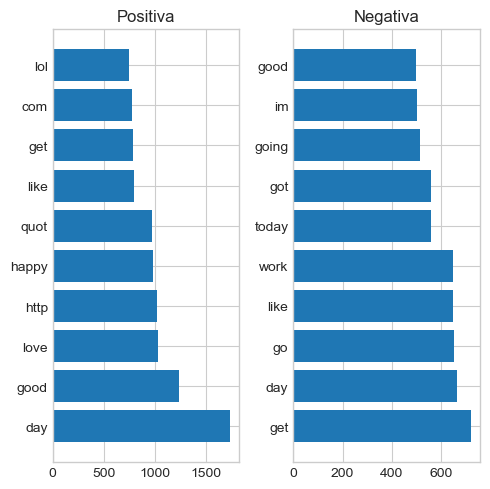

In [17]:
plt.figure(figsize=(5,5))
for index, sent in enumerate(df['emociones'].unique()):
    plt.subplot(1,2,index+1)
    word_count_by_clasif(cv_a, df, 'content', 'emociones', sent,sort_n=10)
    plt.title(sent)
    plt.tight_layout()

* http en una palabra con alta frecuencia nos indica que hay sitios webs entremedio de las palabras.
* las palabras negativas no se aprecian objetivamente negativas.

##### 2.1.1.b Metodo 2: Lematizacion

* Lematizacion: Es decir, el lema de una palabra es la palabra que nos encontraríamos como entrada en un diccionario tradicional: singular para sustantivos, masculino singular para adjetivos, infinitivo...

In [18]:
#Descargar listas de palabras para la lematizacion
nltk.download('wordnet')
nltk.download('omw-1.4')

# lematizador de word net lemmatizer
lemmatizer = WordNetLemmatizer()

# función que lematice el texto y devuelva una lista de tokens
def lemmatize_text(text):
    return [lemmatizer.lemmatize(word) for word in text.split()]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [19]:
# Ejemplo de texto (sin sentido)
prueba = lemmatize_text('My mother is the mothers of motherasdf')
prueba

['My', 'mother', 'is', 'the', 'mother', 'of', 'motherasdf']

Transforma correctamente la palabra mothers pero no motherasdf

In [20]:
cv_b = CountVectorizer(stop_words=stops, tokenizer=lemmatize_text)
frec_b = df_palabras_frecuencia(cv_b, df['content'])
print(frec_b.shape)
detalle_freq1(frec_b, columna='freq')

(58142, 2)
Contiene 43569 elementos con frecuencia igual o menor a 1: 74.94 %
                      word freq
1575        (half-assedly)    1
32345                 him)    1
58116                 ï¿½3    1
29248                four,    1
43460             patient!    1
25738              dirty?'    1
34698                ilife    1
33019  http://bit.ly/253ce    1
53127         tonsillitis.    1
55109              videos)    1
20669              borgata    1
7991             @gleeding    1
24838              darrin.    1
5998              @cindaxo    1
25043                dead!    1


* Al entregarle un tokenizador el parametro analyzer se anula, y por lo visto este parametro filtraba bastantes mas palabras que el tokenizador a través de lemmatizacion.
* aumenta a 75% las palabras con frecuencia 1
* por lo visto en el sample, varias de ellas dificilmente consideradas como palabras estandar y con caracteres especiales.

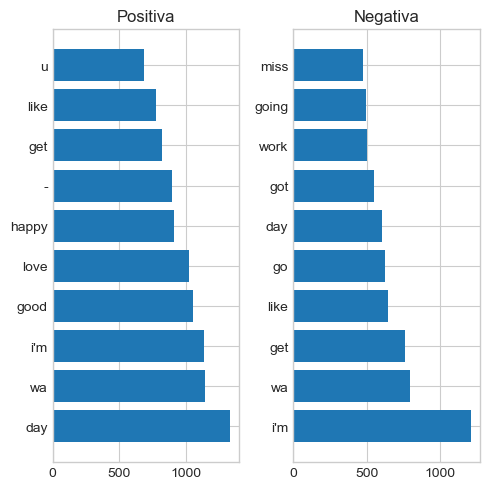

In [21]:
plt.figure(figsize=(5,5))
for index, sent in enumerate(df['emociones'].unique()):
    plt.subplot(1,2,index+1)
    word_count_by_clasif(cv_b, df, 'content', 'emociones', sent,sort_n=10)
    plt.title(sent)
    plt.tight_layout()

* Parece empeorar la condicion de las mejores palabras

##### 2.1.1.c.1 Metodo 3: Funcion tokenizadora.

Como ya se vio en el punto anterior el utilizar un tokenizer anula el parametro analyzer por defecto 'word' por lo que se debe crear una funcion completa que haga lo que se requiere filtrar.

La funcion tokenizer se mantendra en el archivo principal, dado que funcionara a modo explicativo, el paso a paso del filtro.

In [22]:
def tokenizer(text):
    lista_palabras = text.split()
    
    # Seleccionar solo cadenas de letras
    for n, palabra in enumerate(lista_palabras):
        palabra = re.sub(r'[^a-zA-Z]', '', palabra)
        palabra = ' '.join(palabra.split()) # Remover espacios en blanco adicionales
        lista_palabras[n] = palabra

    # Remover ''s' al final de las palabras y cambiar a minusculas
    lista_palabras = [word.replace("'s", "").lower() for word in lista_palabras] 

    # Lematizacion para nouns y vervs
    lemm = WordNetLemmatizer()
    lista_palabras =  [lemm.lemmatize(word, 'n') for word in lista_palabras]
    lista_palabras =  [lemm.lemmatize(word, 'v') for word in lista_palabras]

    # transformar mom, mum, mummy en mother
    codex = {'mom':'mother', 'mum':'mother', 'mummy':'mother', 'mommy':'mother', 'mama':'mother'}
    lista_palabras = [palabra if palabra not in codex else 'mother' for palabra in lista_palabras]

    #quitar sitios web
    lista_palabras = [palabra for palabra in lista_palabras if 'www' not in palabra]   
    lista_palabras = [palabra for palabra in lista_palabras if 'http' not in palabra]   
    
    # Quitar la palabra mother dado el gran ruido y poca objetividad de la palabra.
    lista_palabras = [palabra for palabra in lista_palabras if 'mother' not in palabra]

    # Seleccionar solo palabras de con mas de 3 caracteres
    output = [palabra for palabra in lista_palabras if len(palabra) >= 3]

    return output

In [23]:
# Ejemplo de texto sin sentido
prueba = tokenizer("My mother's mommy mom mummy the mothers run as ran from motherasdf ï¿½ï¿½we www.amazon.com")
prueba

['the', 'run', 'run', 'from']

* Solo queda morherasdf, que podria eliminar haciendo un filtro especifico para esta palabra, sin embargo esto no tiene sentido en la implementación a gran escala.
* Para eliminar dichas palabras seria preferible filtrar por frecuencias dentro del CV.

In [24]:
cv_c = CountVectorizer(stop_words=stops, tokenizer=tokenizer)
frec_c = df_palabras_frecuencia(cv_c, df['content'])
print(frec_c.shape)
detalle_freq1(frec_c, columna='freq')

(36185, 2)
Contiene 26714 elementos con frecuencia igual o menor a 1: 73.83 %
               word freq
4331     burninghat    1
1584    apparantley    1
21012         moron    1
23780  peacecharade    1
33737    uswitchnet    1
4310     buongiorno    1
11427        gahaha    1
3547       bobrules    1
31741  theroomstops    1
28085    sennheiser    1
10118     facepanda    1
12562       guiness    1
21            aaaau    1
957        alwaysss    1
12986     hateeeeee    1


Las frecuencias igual a 1 siguen siendo 74% de los datos, sin embargo ahora al menos notamos que tienen mas sentido que antes, libres de caracteres especiales.

* checkear espacios en blanco

In [25]:
frec_c.loc[frec_c['word']== '']

,word,freq


* checkear verbos conjugados

In [26]:
print(frec_c.loc[frec_c['word']== 'ran'])
print('----------------------------------------------------------------')
print(frec_c.loc[frec_c['word']== 'run'])

Empty DataFrame
Columns: [word, freq]
Index: []
----------------------------------------------------------------
      word freq
27246  run  221


In [27]:
frec_c.loc[frec_c['word']== 'run']

,word,freq
27246,run,221


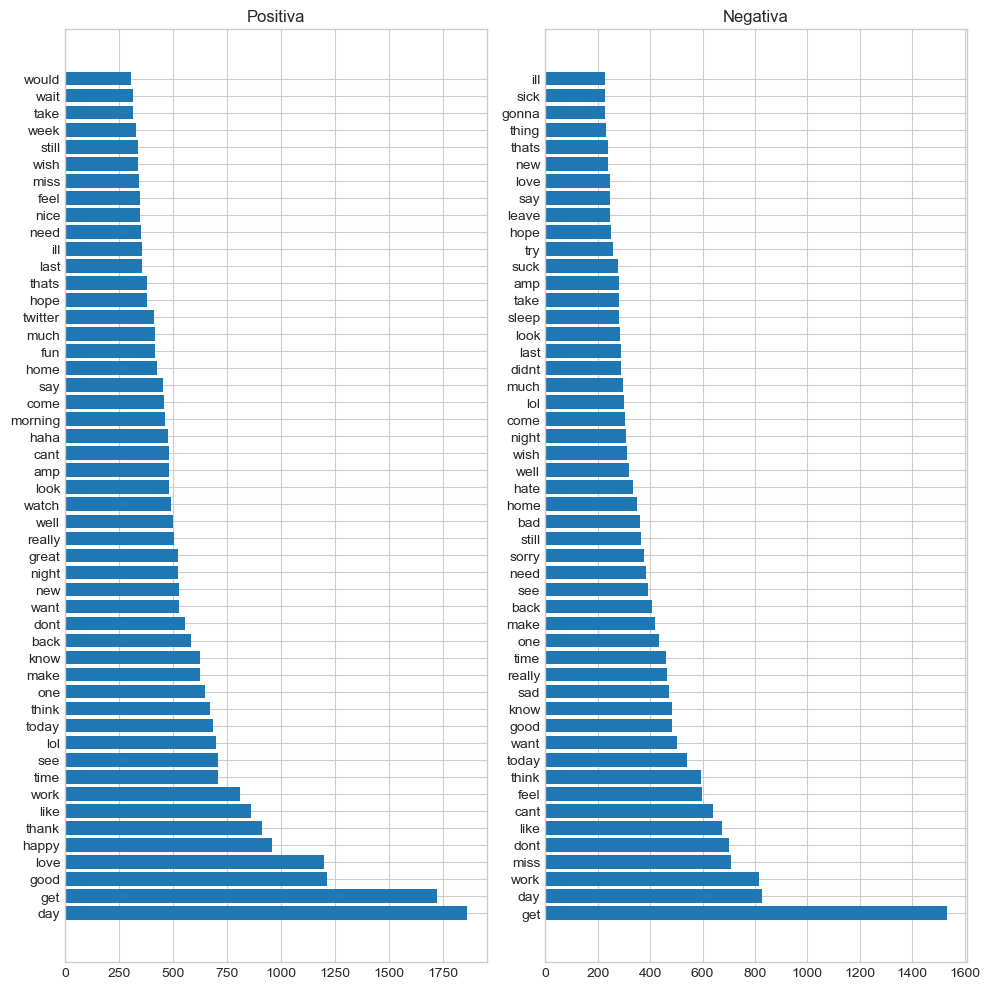

In [28]:
plt.figure(figsize=(10,10))
for index, sent in enumerate(df['emociones'].unique()):
    plt.subplot(1,2,index+1)
    word_count_by_clasif(cv_c, df, 'content', 'emociones', sent,sort_n=50)
    plt.title(sent)
    plt.tight_layout()

* Por primera vez se logra captar un efecto realmente negativo en las palabras de categoria negativa.
    - sad
    - feel (por si sola no es negativa pero podria ser indicio un feel bad)
    - miss
    - cant
    - dont

##### 2.1.1.d Metodo 4: Tokenizador mas Frases.

* Finalmente a modo de darle sentido a nuestras palabras, se evalúan palabras de en ngram_range (3,3).
* Ademas se filtrarán los valores de frecuencia = 1, ya que la matriz crece de forma muy significativa y el computador no es capaz de generar la transformacion con min_df=1, por ende se deja en min_df=2

In [29]:
cv_c2 = CountVectorizer(stop_words=stops, min_df=2,
                      tokenizer=tokenizer, ngram_range=(3,3))
frec_c2 = df_palabras_frecuencia(cv_c2, df['content'])
print(frec_c2.shape)
detalle_freq1(frec_c2, columna='freq', minfreq=2)

(2618, 2)
Contiene 2038 elementos con frecuencia igual o menor a 2: 77.85 %
                        word freq
1634          night time bed    2
745          get better know    2
1622      nice weather today    2
451        doesnt sound good    2
16         alllyy get iphone    2
1985       sooo happy ashley    2
13           ahhhh soo smart    2
1481    melluffsyew umm yeah    2
1175          java work hmph    2
1464         math test today    2
2377        wait till august    2
243           cant vote stop    2
1732  post hellotxt facebook    2
49        another puppy cool    2
1569          need read good    2


* Si aumentamos al minimo de frecuencia igual a 2, se observa un 77% de elementos.

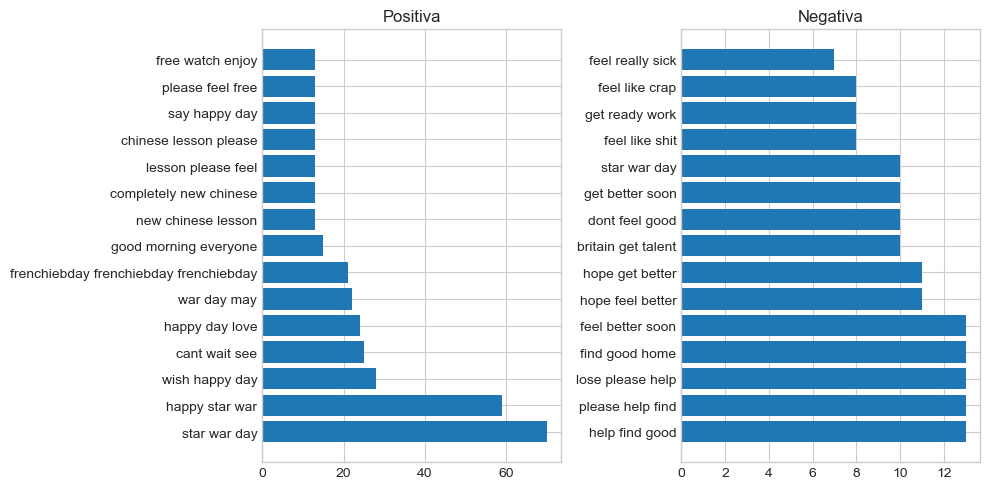

In [30]:
plt.figure(figsize=(10,5))
for index, sent in enumerate(df['emociones'].unique()):
    plt.subplot(1,2,index+1)
    word_count_by_clasif(cv_c2, df, 'content', 'emociones', sent,sort_n=15)
    plt.title(sent)
    plt.tight_layout()

##### 2.1.1.d Metodo 5: Tokenizador simplificado.

* Dado el ejercicio anterior, se aprecia el aumento de sesgo generado por el tokenizador, dado esto se creará un tokenizador mas general para evaluarlo con un modelo y ver su comportamiento.

In [31]:
tf_d = TfidfVectorizer(
    analyzer='word',
    stop_words= stops,
    use_idf = True,
    max_features= 5000,
    max_df = .1
)

In [32]:
frec_d = df_palabras_frecuencia(tf_d, df['content'])
print(frec_d.shape)

(5000, 2)


In [33]:
detalle_freq1(frec_d, columna='freq', minfreq=2)

Contiene 185 elementos con frecuencia igual o menor a 2: 3.70 %
                 word      freq
3013              nhl  1.732466
991        convenient  1.977797
3017            nicer  1.751411
4674            users  1.763485
905       coincidence  1.923609
1485          example  1.934936
3228  patricklanglois  1.816628
2927         munching  1.577412
3009        newspaper  1.901142
2723          measure  1.970737
2895            moves   1.94394
2710            mayer  1.832435
3319            pilot  1.625482
4691       vegetarian  1.941763
2699          matinee  1.855062


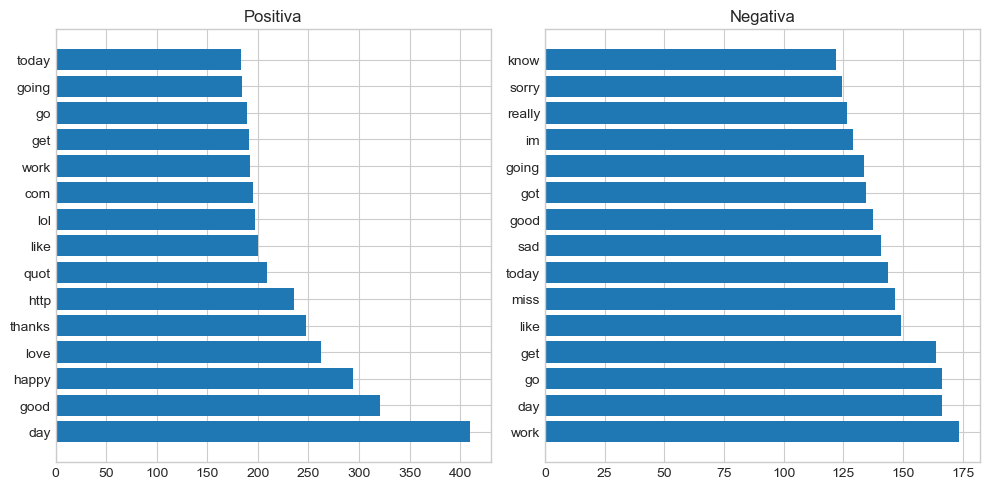

In [34]:
plt.figure(figsize=(10,5))
for index, sent in enumerate(df['emociones'].unique()):
    plt.subplot(1,2,index+1)
    word_count_by_clasif(tf_d, df, 'content', 'emociones', sent,sort_n=15)
    plt.title(sent)
    plt.tight_layout()

* Vuelven a aparecer elementos poco normales.
* Valorar que aun se encuentra la diferencia entre una y otra categoría

##### 2.1.2 Conclusion

* Los tokenizadores basicos de lams y stop words no son suficientes para limpiar la informacion de los tweets, el principal motivo es la libertad que tiene el emisor al escribir, por ende presentan distintos uso de slangs, distintas faltas de ortografia.
* Es por esto que el estudio proseguirá mediante un tokenizador creado con el fin de generalizar los tweets, en este caso se aplicara un filtro especifico para el dia de la madre, ya que con eso es suficiente para evitar problemas de recursos computacionales y se adapta a los datos trabajados. 
* Notar que el filtro del dia de la madre es bastante especifico, quizas se puede ampliar a otros contextos en una implementación mas generalizada como cumpleaños, año nuevo, navidad...

##### 2.1.3 Reduccion de dimensionalidad

* Dado lo observado en el punto anterior seleccionamos la metodologia 3 y 5, el metodo 4 lo desecharemos por tener alta perdida de informacion mediante la agrupacion de palabras.
    - cv_c : Tokenizador agrupado por palabras sin reducir la frecuencia
    - cv_d : Tokenizador mas holgado por palabras sin reducir la frecuencia

cv_c

In [35]:
# Matrix Parametros c
cv_c_fit = cv_c.fit_transform(df['content'])
x_c = cv_c_fit.toarray()
x_c.shape

(30000, 36185)

In [36]:
dimred_c = PCA(n_components = 10, whiten=True)
project_x = dimred_c.fit_transform(x_c)
X_redu_c = pd.DataFrame(project_x)

cv_c2

In [37]:
# Matrix Parametros c
cv_c2_fit = cv_c2.fit_transform(df['content'])
x_c2= cv_c2_fit.toarray()
x_c2.shape

(30000, 2618)

In [38]:
dimred_c2 = PCA(n_components = 10, whiten=True)
project_x = dimred_c2.fit_transform(x_c2)
X_redu_c2 = pd.DataFrame(project_x)

In [39]:
# Matrix Parametros d
cv_fit = tf_d.fit_transform(df['content'])
x_d = cv_fit.toarray()
x_d.shape

(30000, 5000)

In [40]:
dimred_d = PCA(n_components = 10,  whiten=True)
project_x = dimred_d.fit_transform(x_d)
X_redu_d = pd.DataFrame(project_x)

### 2.2 - Modelacion

#### 2.2.0 - Análisis de comportamiento matriz X (matriz de fraces) y vector objetivo

In [41]:
#obtenemos los dummies del vector y 
# 1 = positive
# 0 = negative
y = df['emociones']
y_bin = pd.get_dummies(y, drop_first=True)
y_bin.value_counts()

Positiva
1           17978
0           12022
dtype: int64

##### 2.2.0.a - Modelo de Prueba para seleccionar matriz de atributos X

* Metodo 3: cv_c

In [42]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_redu_c,
        y_bin,test_size=.33,random_state=1991)

In [43]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_c, y_train_c)
yhat_train= lda.predict(X_train_c)
yhat_test= lda.predict(X_test_c)
#Indicadores con Train
print(classification_report(y_train_c, yhat_train))
#Indicadores con Test
print(classification_report(y_test_c, yhat_test))

              precision    recall  f1-score   support

           0       0.54      0.14      0.23      8000
           1       0.62      0.92      0.74     12100

    accuracy                           0.61     20100
   macro avg       0.58      0.53      0.48     20100
weighted avg       0.59      0.61      0.53     20100

              precision    recall  f1-score   support

           0       0.55      0.15      0.23      4022
           1       0.61      0.92      0.73      5878

    accuracy                           0.60      9900
   macro avg       0.58      0.53      0.48      9900
weighted avg       0.58      0.60      0.53      9900



* Deficiente para categoria 0.
* Buen rendimiento en categoria 1.
* Regular comportamiento general 10% mejor que un ejercicio aleatorio. 50-50

* Metodo 4: cv_c2


In [44]:
X_train_c2, X_test_c2, y_train_c2, y_test_c2 = train_test_split(X_redu_c2,
        y_bin,test_size=.33,random_state=1991)

In [45]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_c2, y_train_c2)
yhat_train= lda.predict(X_train_c2)
yhat_test= lda.predict(X_test_c2)
#Indicadores con Train
print(classification_report(y_train_c2, yhat_train))
#Indicadores con Test
print(classification_report(y_test_c2, yhat_test))

              precision    recall  f1-score   support

           0       0.78      0.00      0.00      8000
           1       0.60      1.00      0.75     12100

    accuracy                           0.60     20100
   macro avg       0.69      0.50      0.38     20100
weighted avg       0.67      0.60      0.45     20100

              precision    recall  f1-score   support

           0       0.86      0.00      0.00      4022
           1       0.59      1.00      0.75      5878

    accuracy                           0.59      9900
   macro avg       0.73      0.50      0.37      9900
weighted avg       0.70      0.59      0.44      9900



* Metodo no logra captar la clasificacion negativa

* Metodo 5: tf_d

In [46]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_redu_d,
        y_bin,test_size=.33,random_state=1991)

In [47]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_d, y_train_d)
yhat_train= lda.predict(X_train_d)
yhat_test= lda.predict(X_test_d)
#Indicadores con Train
print(classification_report(y_train_d, yhat_train))
#Indicadores con Test
print(classification_report(y_test_d, yhat_test))

              precision    recall  f1-score   support

           0       0.51      0.06      0.10      8000
           1       0.61      0.96      0.75     12100

    accuracy                           0.60     20100
   macro avg       0.56      0.51      0.42     20100
weighted avg       0.57      0.60      0.49     20100

              precision    recall  f1-score   support

           0       0.55      0.06      0.12      4022
           1       0.60      0.96      0.74      5878

    accuracy                           0.60      9900
   macro avg       0.58      0.51      0.43      9900
weighted avg       0.58      0.60      0.49      9900



* Peor rendimiento para categoria 0.
* Mantiene el rendimiento en categoria 1.
* Baja rendimiento global 10% mejor que el ejericio aleatorio.

* **El mejor resultado se logra con el algoritmo de C utilizando el tokenizador completo, aun que sea levemente.**

##### 2.2.0.b - Modelo de prueba SVM (segun hipotesis) para seleccionar Vector objetivo.

In [48]:
X_train_neu, X_test_neu, y_train_neu, y_test_neu = train_test_split(X_redu_c,
        df['emociones_neu'],test_size=.33,random_state=1991)

In [49]:
svc =SVC()
svc.fit(X_train_c, y_train_neu)
yhat_train= svc.predict(X_train_neu)
yhat_test= svc.predict(X_test_neu)
#Indicadores con Train
print(classification_report(y_train_neu, yhat_train))
#Indicadores con Test
print(classification_report(y_test_neu, yhat_test))

              precision    recall  f1-score   support

    Negativa       0.46      0.80      0.59      8000
    Positiva       0.58      0.47      0.52      7734
     neutral       0.88      0.00      0.01      4366

    accuracy                           0.50     20100
   macro avg       0.64      0.42      0.37     20100
weighted avg       0.60      0.50      0.43     20100

              precision    recall  f1-score   support

    Negativa       0.46      0.79      0.58      4022
    Positiva       0.57      0.45      0.51      3793
     neutral       0.00      0.00      0.00      2085

    accuracy                           0.49      9900
   macro avg       0.34      0.41      0.36      9900
weighted avg       0.41      0.49      0.43      9900



* Se logra capturar de mejor manera los valores negativos, a coste de gran perdida en los positivos.
    - Evaluemos quitar los neutrales de la base de datos.

In [50]:
df_clear = df.loc[df['emociones_neu'] != 'neutral']

In [51]:
# Matrix Parametros sin neutrales transformado con cv_c
cvclear_fit = cv_c.transform(df_clear['content'])

In [52]:
cvclear_fit.shape

(23549, 36185)

In [53]:
# Matrix Parametros c con matriz sin neutrales
Xclear_C = cvclear_fit.toarray()
dimred_clear = PCA(n_components = 10,  whiten=True)
project_x = dimred_clear.fit_transform(Xclear_C)
Xclear_redu = pd.DataFrame(project_x)

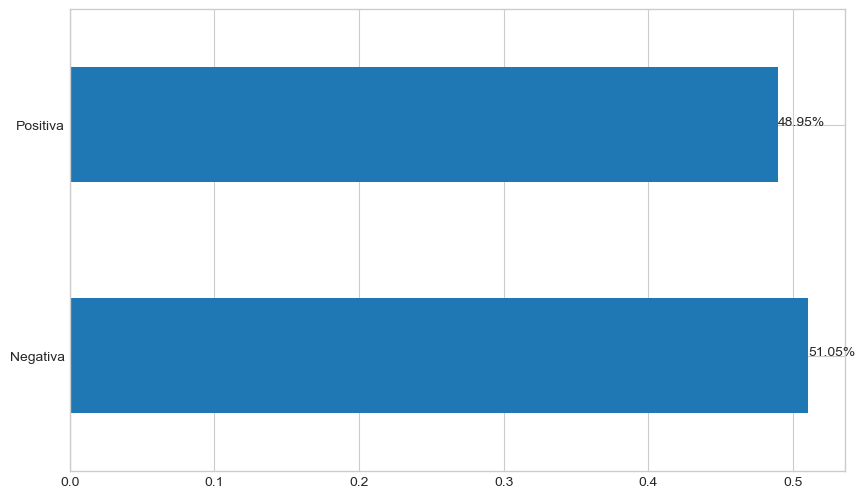

In [54]:
yclear = df_clear['emociones']
graficar_porcentajes_cat(yclear)

In [55]:
yclear_bin = pd.get_dummies(yclear, drop_first=True)
yclear_bin.value_counts()

Positiva
0           12022
1           11527
dtype: int64

In [56]:
Xclear_train, Xclear_test, yclear_train, yclear_test = train_test_split(Xclear_redu,
        yclear_bin,test_size=.33,random_state=1991)

In [57]:
svm = SVC()
svm.fit(Xclear_train, yclear_train)
yhat_train= svm.predict(Xclear_train)
yhat_test= svm.predict(Xclear_test)
#Indicadores con Train
print(classification_report(yclear_train, yhat_train))
#Indicadores con Test
print(classification_report(yclear_test, yhat_test))


              precision    recall  f1-score   support

           0       0.62      0.80      0.70      8057
           1       0.70      0.49      0.58      7720

    accuracy                           0.65     15777
   macro avg       0.66      0.64      0.64     15777
weighted avg       0.66      0.65      0.64     15777

              precision    recall  f1-score   support

           0       0.61      0.78      0.68      3965
           1       0.67      0.47      0.55      3807

    accuracy                           0.63      7772
   macro avg       0.64      0.63      0.62      7772
weighted avg       0.64      0.63      0.62      7772



* Al desechar las observaciones clasificadas aleatoriamente se logra capturar ambas clases sobre el 50% en el primer modelo estudiado.
* Sin embargo, al quitarle dichas observaciones al modelo, se estan quitando registros que pueden aportar informacion.
* Es por esto que dejaremos estas matrices guardadas para implementarlas en el modelo final, ya que sería interezante comprobar cual modelo se comportaría mejor frente a una tweets nuevos.

#### 2.2.1 Modelacion

Dividir matrices

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_redu_c,
        y_bin,test_size=.33,random_state=1991)

In [59]:
print(f'''{X_train.shape}
{X_test.shape}
{y_train.shape}
{y_test.shape}
''')

(20100, 10)
(9900, 10)
(20100, 1)
(9900, 1)



##### 2.2.1.1 - Modelo 1: LDA

* Valores en estudio por defecto:
    - solver = 'svd'
    - shrinkage = 'none'
    - priors = valor se infiere desde la data
    - n_components = none implica el minimo

In [60]:
lda1_tr, lda1_ts = modelacion_inicial(LinearDiscriminantAnalysis(), X_redu_c, y_bin, guardar=True)

Metricas en entrenamiento
                  precision    recall  f1-score   support

           0       0.54      0.14      0.23      8000
           1       0.62      0.92      0.74     12100

    accuracy                           0.61     20100
   macro avg       0.58      0.53      0.48     20100
weighted avg       0.59      0.61      0.53     20100

Metricas en Testeo
                  precision    recall  f1-score   support

           0       0.55      0.15      0.23      4022
           1       0.61      0.92      0.73      5878

    accuracy                           0.60      9900
   macro avg       0.58      0.53      0.48      9900
weighted avg       0.58      0.60      0.53      9900

    


* Deficiente para categorizar negativos.
* Efectivo para categorizar positivos.
* Rendimiento general moderado con 10% sobre el ejercicio aleatorio.

#### 2.2.1.2 Modelo 2 SVC

* Parametros para la grilla
    - C : [float] default=1.0 = parametro de regularizacion
    - kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
    - degree: int, default=3 : grado del polinomio del kernel 
    - gamma: {‘scale’, ‘auto’} or float, default=’scale’: Coeficiente del kernel
    - random_state

In [61]:
svc1_tr, svc1_ts = modelacion_inicial(SVC(), X_redu_c, y_bin, guardar=True)

Metricas en entrenamiento
                  precision    recall  f1-score   support

           0       0.67      0.20      0.30      8000
           1       0.64      0.94      0.76     12100

    accuracy                           0.64     20100
   macro avg       0.65      0.57      0.53     20100
weighted avg       0.65      0.64      0.58     20100

Metricas en Testeo
                  precision    recall  f1-score   support

           0       0.60      0.18      0.27      4022
           1       0.62      0.92      0.74      5878

    accuracy                           0.62      9900
   macro avg       0.61      0.55      0.51      9900
weighted avg       0.61      0.62      0.55      9900

    


* Deficiente para categorizar negativos.
* Efectivo para categorizar positivos.
* Rendimiento general moderado con 12% sobre el ejercicio aleatorio 50-50.

#### 2.2.1.3 Modelo 3 Random tree y Random Forest

* Parametros:
    - n_estimators: default=100
    - criterion: “gini”, “entropy”, “log_loss”, default=”gini”
    - max_depth: profundidad default: none = nodos expandidos hasta que las hojas contengan min_samples_split samples o puras
    - min_samples_split: default=2 : minimo numero de samples para separar un nodo, un valor mayor puede reducir el riesgo de sobreajuste
    - min_samples_leaf: default=1 : este parámetro controla el número mínimo de muestras que se requieren en cada hoja del árbol. Un valor mayor puede hacer que el modelo sea más generalizado
    - max_features{“sqrt”, “log2”, None}, int or float, default=”sqrt”
    - warm_start: default=False: True = Reutiliza la solucion previa para entrenar y agregar mas estimadores.
    - random_state

In [62]:
dtc1_tr, dtc1_ts = modelacion_inicial(DecisionTreeClassifier(), X_redu_c, y_bin, guardar=True)

Metricas en entrenamiento
                  precision    recall  f1-score   support

           0       0.99      0.99      0.99      8000
           1       0.99      0.99      0.99     12100

    accuracy                           0.99     20100
   macro avg       0.99      0.99      0.99     20100
weighted avg       0.99      0.99      0.99     20100

Metricas en Testeo
                  precision    recall  f1-score   support

           0       0.48      0.47      0.47      4022
           1       0.64      0.65      0.65      5878

    accuracy                           0.58      9900
   macro avg       0.56      0.56      0.56      9900
weighted avg       0.58      0.58      0.58      9900

    


* Deficiente para categorizar negativos.
* moderado para categorizar positivos.
* Rendimiento general moderado con 8% sobre el ejercicio aleatorio 50-50.
* En relacion al train, notar el alto sobre ajuste en la muestra en la cual se entreno.
* Malo en generalizar información


In [63]:
rndf1_tr, rndf1_ts = modelacion_inicial(RandomForestClassifier(), X_redu_c, y_bin, guardar=True)

Metricas en entrenamiento
                  precision    recall  f1-score   support

           0       0.99      0.98      0.99      8000
           1       0.99      1.00      0.99     12100

    accuracy                           0.99     20100
   macro avg       0.99      0.99      0.99     20100
weighted avg       0.99      0.99      0.99     20100

Metricas en Testeo
                  precision    recall  f1-score   support

           0       0.58      0.44      0.50      4022
           1       0.67      0.78      0.72      5878

    accuracy                           0.64      9900
   macro avg       0.62      0.61      0.61      9900
weighted avg       0.63      0.64      0.63      9900

    


* Moderado para categorizar negativos.
* Efectivo para categorizar positivos.
* Rendimiento general moderado con 14% sobre el ejercicio aleatorio.
* Al igual que el arbol de decision en su muestra de entrenamiento muestra un alto sobre ajuste.
* Malo en generalizar información

Random forest es superior al decision tree

Observemos el comportamiento en la matriz 'clear' sin la clase neutral.

In [64]:
rndfclear_tr, rndfclear_ts = modelacion_inicial(RandomForestClassifier(), Xclear_redu, yclear_bin, guardar=True)

Metricas en entrenamiento
                  precision    recall  f1-score   support

           0       0.99      0.99      0.99      8057
           1       0.99      0.99      0.99      7720

    accuracy                           0.99     15777
   macro avg       0.99      0.99      0.99     15777
weighted avg       0.99      0.99      0.99     15777

Metricas en Testeo
                  precision    recall  f1-score   support

           0       0.65      0.71      0.68      3965
           1       0.67      0.61      0.64      3807

    accuracy                           0.66      7772
   macro avg       0.66      0.66      0.66      7772
weighted avg       0.66      0.66      0.66      7772

    


* Efectivo para categorizar negativos.
* Moderado a efectivo para categorizar positivos.
* Rendimiento general moderado con 17% sobre el ejercicio aleatorio.
* Malo en generalizar información

* Considerar ingrasar penalizaciones al modelo con random forest para mejorar su resultado

#### 2.2.1.4 Modelo 4 AdaboostClassifier y GradientBoost

* Parametros
    - Estimator: default: DecisionTreeClassifier
    - n_estimators: default: 50 = Numero de clasificadors debiles utilizados en el modelo, a medida que aumenta el modelo se vuelve mas preciso, pero tambien aumenta el tiempo de entrenamiento.
    - Learning rate: default:1.0 = controla la contribución de cada estimador en el conjunto final. Un learning rate alto significa que se da más importancia a la contribución de cada estimador individual, lo que puede llevar a un sobreajuste. Un learning rate bajo significa que cada estimador individual contribuye poco al modelo final, lo que puede llevar a un bajo rendimiento.
    - randomstate

In [65]:
adda_tr, adda_ts = modelacion_inicial(AdaBoostClassifier(), X_redu_c, y_bin, guardar=True)

Metricas en entrenamiento
                  precision    recall  f1-score   support

           0       0.60      0.32      0.42      8000
           1       0.66      0.86      0.74     12100

    accuracy                           0.64     20100
   macro avg       0.63      0.59      0.58     20100
weighted avg       0.63      0.64      0.61     20100

Metricas en Testeo
                  precision    recall  f1-score   support

           0       0.59      0.32      0.41      4022
           1       0.64      0.85      0.73      5878

    accuracy                           0.63      9900
   macro avg       0.62      0.58      0.57      9900
weighted avg       0.62      0.63      0.60      9900

    


* Deficiente para categorizar negativos.
* Efectivo para categorizar positivos.
* Rendimiento general moderado con 13% sobre el ejercicio aleatorio.

* Parametros:
    - loss: ‘log_loss’, ‘deviance’, ‘exponential’, default=’log_loss’= Funcion de perdida a ser optimizada en exponencial  gradient boost toma el algoritmo de adaboost
    - n_estimator: default 100 = un numero alto siele resultar en una mejor performance.
    - subsample: default=1 = fraccion de muestras para ser entrenadas como base del aprendizaje. seleccionar un valor menor a 1 implica reduccion de la varianza debe estar entre 0 y 1
    - min_samples_split: default 2 = min de muestras requeridas para dividir un nodo. Un valor más alto evita divisiones que conducen a regiones con pocas muestras, lo que puede reducir el sobreajuste, pero también puede hacer que el modelo pierda información importante.
    - min_samples_leaf: default 1 = min de muestras requeridas para estar en un nodo de hoja.
    - max_depthi: int - None, default:3 =  La profundidad máxima de cada árbol. Un valor más alto permite que el modelo capture relaciones más complejas, pero también aumenta la posibilidad de sobreajuste.
    - max_features{‘auto’, ‘sqrt’, ‘log2’}, int or float, default=None
    - warm_star: tbool, default: False = Guarda el resultado anterior en la memoria para iterar.
    - randomstate

In [66]:
gboost_tr, gboost_ts = modelacion_inicial(GradientBoostingClassifier(), X_redu_c, y_bin, guardar=True)

Metricas en entrenamiento
                  precision    recall  f1-score   support

           0       0.68      0.33      0.45      8000
           1       0.67      0.89      0.77     12100

    accuracy                           0.67     20100
   macro avg       0.67      0.61      0.61     20100
weighted avg       0.67      0.67      0.64     20100

Metricas en Testeo
                  precision    recall  f1-score   support

           0       0.60      0.30      0.40      4022
           1       0.64      0.86      0.74      5878

    accuracy                           0.64      9900
   macro avg       0.62      0.58      0.57      9900
weighted avg       0.63      0.64      0.60      9900

    


* Deficiente para categorizar negativos.
* Efectivo para categorizar positivos.
* Rendimiento general moderado con 14% sobre el ejercicio aleatorio.

Adaboost muestra un desempeño similar a gradient boost, ada presenta mayor capacidad predictiva en la categoria de los negativos '0', sin embargo se intentara penalizar el gradient boost en busca de mejores resultados.

#### 2.2.1.6 Modelo 6 Multinomial, Gaussian - Naive Bayes.

In [67]:
gnb_tr,gnb_ts = modelacion_inicial(GaussianNB(), X_redu_c, y_bin, guardar=True)

Metricas en entrenamiento
                  precision    recall  f1-score   support

           0       0.48      0.38      0.42      8000
           1       0.64      0.72      0.68     12100

    accuracy                           0.59     20100
   macro avg       0.56      0.55      0.55     20100
weighted avg       0.57      0.59      0.58     20100

Metricas en Testeo
                  precision    recall  f1-score   support

           0       0.47      0.38      0.42      4022
           1       0.63      0.71      0.67      5878

    accuracy                           0.58      9900
   macro avg       0.55      0.54      0.54      9900
weighted avg       0.56      0.58      0.57      9900

    


* Deficiente para categorizar negativos.
* Efectivo para categorizar positivos.
* Rendimiento general moderado con 8% sobre el ejercicio aleatorio.

**Importante**: Muiltinomial solo acepta valores 0 o 1, por lo que no se puede trabajar con la matriz a la cual se le redujo la dimensionalidad.

In [68]:
nb_tr,nb_ts = modelacion_inicial(MultinomialNB(),x_c, y_bin, guardar=True)

Metricas en entrenamiento
                  precision    recall  f1-score   support

           0       0.88      0.79      0.83      8000
           1       0.87      0.93      0.90     12100

    accuracy                           0.87     20100
   macro avg       0.88      0.86      0.87     20100
weighted avg       0.88      0.87      0.87     20100

Metricas en Testeo
                  precision    recall  f1-score   support

           0       0.64      0.57      0.60      4022
           1       0.72      0.78      0.75      5878

    accuracy                           0.69      9900
   macro avg       0.68      0.67      0.68      9900
weighted avg       0.69      0.69      0.69      9900

    


* Efectivo para categorizar negativos.
* Efectivo para categorizar positivos.
* Rendimiento general bueno con 19% sobre el ejercicio aleatorio 50-50.
* Se debe evaluar la penalización en busca de mejores metricas entre train y test

#### 2.2.1.5 Modelo 5 Voting

Se evalúan dos modelos de votacion, con PCA y sin PCA

* parametros:
    - Estimators: una lista de estimadores a utilizar. Cada estimador debe ser un objeto de clasificación o regresión que tenga los métodos fit y predict.
    - Voting: default: hard = Tipo de votación a utilizar. Puede ser 'hard' (predicciones discretas) o 'soft' (predicciones de probabilidad).
    - weights: una lista de pesos que se aplican a cada estimador. Los pesos pueden utilizarse para ajustar la importancia de cada estimador en la votación final.
    - flatten_transform: un parámetro booleano que indica si se deben aplanar los resultados de la transformación predictiva. Si se establece en True, los resultados se aplanan en una matriz unidimensional.

In [69]:
estimators = [
    ('svc', SVC()),
    ('Gradient Boost',GradientBoostingClassifier()),
    ('Random forest', RandomForestClassifier()),
]

In [70]:
vote1pca_tr, vote1pca_ts = modelacion_inicial(VotingClassifier(estimators), X_redu_c, y_bin, guardar=True)

Metricas en entrenamiento
                  precision    recall  f1-score   support

           0       0.85      0.37      0.52      8000
           1       0.70      0.96      0.81     12100

    accuracy                           0.72     20100
   macro avg       0.78      0.67      0.66     20100
weighted avg       0.76      0.72      0.69     20100

Metricas en Testeo
                  precision    recall  f1-score   support

           0       0.62      0.28      0.39      4022
           1       0.64      0.88      0.74      5878

    accuracy                           0.64      9900
   macro avg       0.63      0.58      0.57      9900
weighted avg       0.63      0.64      0.60      9900

    


* Deficiente para categorizar negativos.
* Efectivo para categorizar positivos.
* Rendimiento general moderado con 14% sobre el ejercicio aleatorio.

#### 2.2.2 Evaluación del modelamiento


* Los mejores resultados se obtienen con Voting, Random Forest y Gradient Boost.
* Se mejoraran los parametros de todos los 5 modelos principales, para seleccionar los mejores modelos.

## Hito 3

### 3.1 Modelacion (Segunda y tercera iteracion)

#### 3.1.1 Modelación segunda y tercera iteración

##### 2.2.1.1 Modelo 1 LDA

Buscar la mejor ponderacion mediante priors y el mejor algoritmo de optimizacion solver'.

* Valores en estudio de grilla:
    - solver = ['svd', 'lsqr', 'eigen'] : tipo de modelo
    - priors = [.35,.65],[.4,.6],[.45,.55],[.55,.45],[.6,.4],[.65,.35]: probabilidades propuestas
* Parametro fijo n_components = 2 para que el modelo LDA reduzca las dimensiones a 2 positivas y negativas.

In [71]:
param_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'priors': [[.35,.65],[.4,.6],[.45,.55],[.55,.45],[.6,.4],[.65,.35]]
}

In [72]:
model_lda = GridSearchCV(LinearDiscriminantAnalysis(n_components=1),
                        param_lda,
                        cv=5,
                        n_jobs=-1,
                        verbose=5,
                        )
model_lda.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(n_components=1),
             n_jobs=-1,
             param_grid={'priors': [[0.35, 0.65], [0.4, 0.6], [0.45, 0.55],
                                    [0.55, 0.45], [0.6, 0.4], [0.65, 0.35]],
                         'solver': ['svd', 'lsqr', 'eigen']},
             verbose=5)

In [73]:
print(model_lda.best_params_)
yhat_lda_tr = model_lda.best_estimator_.predict(X_train)
yhat_lda_ts = model_lda.best_estimator_.predict(X_test)
lda2_tr = classification_report(y_train, yhat_lda_tr)
lda2_ts = classification_report(y_test, yhat_lda_ts)


{'priors': [0.35, 0.65], 'solver': 'svd'}


In [74]:
print(lda2_tr)
print(lda2_ts)

              precision    recall  f1-score   support

           0       0.58      0.07      0.13      8000
           1       0.61      0.97      0.75     12100

    accuracy                           0.61     20100
   macro avg       0.60      0.52      0.44     20100
weighted avg       0.60      0.61      0.50     20100

              precision    recall  f1-score   support

           0       0.58      0.07      0.13      4022
           1       0.60      0.96      0.74      5878

    accuracy                           0.60      9900
   macro avg       0.59      0.52      0.44      9900
weighted avg       0.59      0.60      0.49      9900



No se observa mejora en modelo. Se descarta.

#### 2.2.1.2 Modelo 2 SVC

Se iteran sus principales parametros 'C' y 'Gamma', dado el cosumo de recursos se acota la grilla en el minimo, sin embargo se realizaron varias iteraciones a modo de prueba para intentar encontrar la mejor grilla.

In [75]:
param_svc = {
    'C' : [1,100],
    'gamma': [10, 100],
    'kernel': ['rbf'],

}
model_svc = GridSearchCV(SVC(random_state=1991),
                        param_svc,
                        cv=3,
                        n_jobs=-1,
                        verbose=5,
                        )
model_svc.fit(X_train, y_train)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=SVC(random_state=1991), n_jobs=-1,
             param_grid={'C': [1, 100], 'gamma': [10, 100], 'kernel': ['rbf']},
             verbose=5)

In [76]:
print(model_svc.best_params_)
yhat_svc_tr = model_svc.best_estimator_.predict(X_train)
yhat_svc_ts = model_svc.best_estimator_.predict(X_test)
svc2_tr = classification_report(y_train, yhat_svc_tr)
svc2_ts = classification_report(y_test, yhat_svc_ts)

{'C': 1, 'gamma': 10, 'kernel': 'rbf'}


In [77]:
print(svc2_tr)
print(svc2_ts)

              precision    recall  f1-score   support

           0       0.83      0.52      0.64      8000
           1       0.75      0.93      0.83     12100

    accuracy                           0.77     20100
   macro avg       0.79      0.72      0.73     20100
weighted avg       0.78      0.77      0.75     20100

              precision    recall  f1-score   support

           0       0.59      0.27      0.38      4022
           1       0.64      0.87      0.74      5878

    accuracy                           0.63      9900
   macro avg       0.62      0.57      0.56      9900
weighted avg       0.62      0.63      0.59      9900



* El consumo computaiconal de la grilla con SVC es muy alta, en los intentos por ejecutar grillas se itero con:
    - 'C' : [0.01, 1, 100, 1000],
    - 'gamma': [0.1, 1 ,10, 100],
    - 'kernel': ['rbf', 'sigmoid', 'poly'],
* Debido a esto, se itera de forma separada buscando la mejor combinacion. A pesar de que esto no refleja lo que seria una busqueda de grilla completa, de igual manera se logra mejorar de 0.62 a 0.63 la accuracy.
* El modelo parece captar bien los casos positivos con un .74 en f1-score, sin embargo la clase negativa es muy deficiente con menos del .50.

* A costo de aumentar en 1 el acuracy en test, en train aumenta a .77 
* La brecha es bastante, sin embargo no muestra sobre ajuste.
* es deficiente en capturar los 0.
* Se desecha

#### 2.2.1.3 Modelo 3 Random forest

* Parametros:
    - n_estimators: default=100
    - criterion: “gini”, “entropy”, “log_loss”, default=”gini”
    - max_depth: profundidad default: none = nodos expandidos hasta que las hojas contengan min_samples_split samples o puras
    - min_samples_split: default=2 : minimo numero de samples para separar un nodo, un valor mayor puede reducir el riesgo de sobreajuste
    - min_samples_leaf: default=1 : este parámetro controla el número mínimo de muestras que se requieren en cada hoja del árbol. Un valor mayor puede hacer que el modelo sea más generalizado
    - max_features{“sqrt”, “log2”, None}, int or float, default=”sqrt”
    - warm_start: default=False: True = Reutiliza la solucion previa para entrenar y agregar mas estimadores.
    - random_state

In [78]:
param_rforest = {
                'max_depth':[100,10],
                'n_estimators':[1,10],
                'min_samples_split':[0.001,1],
                'min_samples_leaf':[0.001,1],
    }
model_rndforest = GridSearchCV( RandomForestClassifier(random_state=1991,
                                                       n_estimators =10,
                                                       warm_start=True,
                                                       max_features=None),
                               param_grid=param_rforest,
                                cv=5,
                                n_jobs=-1,
                                verbose=5
                            )
model_rndforest.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features=None,
                                              n_estimators=10,
                                              random_state=1991,
                                              warm_start=True),
             n_jobs=-1,
             param_grid={'max_depth': [100, 10], 'min_samples_leaf': [0.001, 1],
                         'min_samples_split': [0.001, 1],
                         'n_estimators': [1, 10]},
             verbose=5)

In [79]:
print(model_rndforest.best_params_)
yhat_rndforest2_tr = model_rndforest.best_estimator_.predict(X_train)
yhat_rndforest2_ts = model_rndforest.best_estimator_.predict(X_test)
rndforest2_tr = classification_report(y_train, yhat_rndforest2_tr)
rndforest2_ts = classification_report(y_test, yhat_rndforest2_ts)

{'max_depth': 10, 'min_samples_leaf': 0.001, 'min_samples_split': 0.001, 'n_estimators': 10}


In [80]:
print(rndforest2_tr)
print(rndforest2_ts)

              precision    recall  f1-score   support

           0       0.71      0.43      0.54      8000
           1       0.70      0.89      0.78     12100

    accuracy                           0.71     20100
   macro avg       0.71      0.66      0.66     20100
weighted avg       0.71      0.71      0.69     20100

              precision    recall  f1-score   support

           0       0.59      0.35      0.44      4022
           1       0.65      0.83      0.73      5878

    accuracy                           0.64      9900
   macro avg       0.62      0.59      0.58      9900
weighted avg       0.63      0.64      0.61      9900



* .71 en el train, mejora la metrica en cuanto a la generalizacion
* .64 en el test mantiene su accuracy
* .44 en capturar la clase negativa, deficiente.
* Guardamos el modelo


Se define el modelo de la siguiente manera:

In [81]:
rndforest = RandomForestClassifier(random_state=1991,  warm_start=True, max_features=None,
                                    criterion='gini', max_depth=100,  min_samples_leaf=0.001, 
                                    min_samples_split=0.001,n_estimators=10 , class_weight={0:1, 1:1})
rndforest.fit(X_train, y_train)
yhat_rf2= rndforest.predict(X_test)

In [82]:
yhat_modelos = {'random forest':yhat_rf2}

* Se puede implementar una distribucion de pesos en el modelo para intentar captar la categoria 0 de negativos.

In [83]:
rndforest0 = RandomForestClassifier(random_state=1991,  warm_start=True, max_features=None,
                                    criterion='gini', max_depth=100,  min_samples_leaf=0.001, 
                                    min_samples_split=0.001,n_estimators=10 , class_weight={0:1, 1:.1})
rndforest0.fit(X_train, y_train)
yhat_rf0= rndforest0.predict(X_test)
print(classification_report(y_test, yhat_rf0))


              precision    recall  f1-score   support

           0       0.43      0.96      0.59      4022
           1       0.83      0.13      0.22      5878

    accuracy                           0.47      9900
   macro avg       0.63      0.54      0.41      9900
weighted avg       0.67      0.47      0.37      9900



* Como se observa, sacrifica gran parte del modelo para encontrar la clase 0 f1 de .59, sin embargo un acuraccy de .47 es muy bajo por si solo.
* Se guarda para comparar.

In [84]:
yhat_modelos['random forest 0'] = yhat_rf0

#### 2.2.1.4 Modelo Gradient boostClassifier

* Parametros:
    - loss: ‘log_loss’, ‘deviance’, ‘exponential’, default=’log_loss’: Funcion de perdida a ser optimizada en exponencial  gradient boost toma el algoritmo de adaboost
    - n_estimator default 100 = un numero alto suele resultar en una mejor performance.
    - subsample: default=1 : fraccion de muestras para ser entrenadas como base del aprendizaje. seleccionar un valor menor a 1 implica reduccion de la varianza debe estar entre 0 y 1
    - min_samples_split default 2 = min de muestras requeridas para dividir un nodo. Un valor más alto evita divisiones que conducen a regiones con pocas muestras, lo que puede reducir el sobreajuste, pero también puede hacer que el modelo pierda información importante.
    - min_samples_leaf default 1 = min de muestras requeridas para estar en un nodo de hoja
    - max_depthi: int - None, default=3 =  La profundidad máxima de cada árbol. Un valor más alto permite que el modelo capture relaciones más complejas, pero también aumenta la posibilidad de sobreajuste.
    - max_features{‘auto’, ‘sqrt’, ‘log2’}, int or float, default=None
    - warm_startbool, default=False
    - randomstate

In [85]:
param_gboost = {'learning_rate':[0.001, 0.01, 1],
               'max_depth':[1, 10],
               'n_estimators':[10,100],
               'subsample':[.1,.3,.4]   
    }
model_gboost = GridSearchCV( GradientBoostingClassifier(random_state=1991),
                               param_grid=param_gboost,
                                cv=5,
                                n_jobs=-1,
                                verbose=5
                            )
model_gboost.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1991),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 1],
                         'max_depth': [1, 10], 'n_estimators': [10, 100],
                         'subsample': [0.1, 0.3, 0.4]},
             verbose=5)

In [86]:
print(model_gboost.best_params_)
yhat_gboost2_tr = model_gboost.best_estimator_.predict(X_train)
yhat_gboost2_ts = model_gboost.best_estimator_.predict(X_test)
gboost2_tr = classification_report(y_train, yhat_gboost2_tr)
gboost2_ts = classification_report(y_test, yhat_gboost2_ts)

{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.3}


In [87]:
print(gboost2_tr)
print(gboost2_ts)

              precision    recall  f1-score   support

           0       0.90      0.37      0.52      8000
           1       0.70      0.97      0.81     12100

    accuracy                           0.73     20100
   macro avg       0.80      0.67      0.67     20100
weighted avg       0.78      0.73      0.70     20100

              precision    recall  f1-score   support

           0       0.64      0.23      0.34      4022
           1       0.63      0.91      0.75      5878

    accuracy                           0.64      9900
   macro avg       0.64      0.57      0.55      9900
weighted avg       0.64      0.64      0.58      9900



* Deficiente para categorizar negativos.
* Efectivo para categorizar positivos.
* Rendimiento general moderado con 14% sobre el ejercicio aleatorio.

In [88]:
print(gboost_tr)
print(gboost_ts)

              precision    recall  f1-score   support

           0       0.68      0.33      0.45      8000
           1       0.67      0.89      0.77     12100

    accuracy                           0.67     20100
   macro avg       0.67      0.61      0.61     20100
weighted avg       0.67      0.67      0.64     20100

              precision    recall  f1-score   support

           0       0.60      0.30      0.40      4022
           1       0.64      0.86      0.74      5878

    accuracy                           0.64      9900
   macro avg       0.62      0.58      0.57      9900
weighted avg       0.63      0.64      0.60      9900



* Gradient boost sin parametros muestra ser mejro opcion que el de la grilla dado al mejor rendimiento en el test, ya que no muestra una gran brecha en comparacion al train .67 vs .64. A diferencia de su par en que train tiene un accuracy de .73 y test .64

Entonces se define el modelo de la siguiente manera y se guarda:

In [89]:
gboost = GradientBoostingClassifier()
gboost.fit(X_train, y_train)
yhat_gboost= gboost.predict(X_test)

In [90]:
#guardamos el modelo para su uso posterior
gboost_clear = GradientBoostingClassifier()

In [91]:
yhat_modelos['gboost'] = yhat_gboost

#### 2.2.1.5 Modelo 5 Voting

* El siguiente modelo es un conjunto de los mejores resultados obtenidos:
    - rndforest para 0: modelo con la mejor capacidad predictiva en la clase 0
    - rndforest balanceado: modelo balanceado, prioriza el 1
    - gboost: uno de los mejores modelos junto al random forest, logra un resultado similar, sin embargo captura de forma distinta las categorias.

In [92]:
estimators = [
    ('rndforest para 0', RandomForestClassifier(random_state=1991,  warm_start=True, max_features=None,
                                    criterion='gini', max_depth=100,  min_samples_leaf=0.001, 
                                    min_samples_split=0.001,n_estimators=10 , class_weight={0:1, 1:.1})), 
    ('rndforest balanceado', RandomForestClassifier(random_state=1991,  warm_start=True, max_features=None,
                                    criterion='gini', max_depth=100,  min_samples_leaf=0.001, 
                                    min_samples_split=0.001,n_estimators=10 , class_weight={0:1, 1:1})),  
    ('gboost', GradientBoostingClassifier())             
]

In [93]:
voting2 = VotingClassifier(estimators)
voting2.fit(X_train, y_train)
yhat_tr= voting2.predict(X_train)
yhat_ts_voting2= voting2.predict(X_test)
print(classification_report(y_train, yhat_tr))
print(classification_report(y_test, yhat_ts_voting2))

              precision    recall  f1-score   support

           0       0.71      0.61      0.65      8000
           1       0.76      0.83      0.80     12100

    accuracy                           0.74     20100
   macro avg       0.74      0.72      0.73     20100
weighted avg       0.74      0.74      0.74     20100

              precision    recall  f1-score   support

           0       0.57      0.46      0.51      4022
           1       0.67      0.76      0.71      5878

    accuracy                           0.64      9900
   macro avg       0.62      0.61      0.61      9900
weighted avg       0.63      0.64      0.63      9900



* Moderado para categorizar negativos.
* Efectivo para categorizar positivos.
* Rendimiento general moderado con 14% sobre el ejercicio aleatorio.

* aumenta un .02 el accuracy de train, sin embargo se logra capturar la categoria negativa con mejor eficacia.

Se modifican los pesos aplicados a los modelos para evaluar su comportamiento.

In [94]:
w1 = [.3, .1, .6 ] # potenciar g boost
w2 = [.4, .5, .1 ] # potenciar forests

In [95]:
voting_w1 = VotingClassifier(estimators, weights=w1)
voting_w1.fit(X_train, y_train)
yhat_tr= voting_w1.predict(X_train)
yhat_ts= voting_w1.predict(X_test)
print(classification_report(y_train, yhat_tr))
print(classification_report(y_test, yhat_ts))

              precision    recall  f1-score   support

           0       0.68      0.33      0.45      8000
           1       0.67      0.89      0.77     12100

    accuracy                           0.67     20100
   macro avg       0.67      0.61      0.61     20100
weighted avg       0.67      0.67      0.64     20100

              precision    recall  f1-score   support

           0       0.60      0.30      0.40      4022
           1       0.64      0.86      0.74      5878

    accuracy                           0.64      9900
   macro avg       0.62      0.58      0.57      9900
weighted avg       0.63      0.64      0.60      9900



* Deficiete para categorizar negativos.
* Efectivo para categorizar positivos.
* Rendimiento general moderado con 14% sobre el ejercicio aleatorio.

In [96]:
voting_w2 = VotingClassifier(estimators, weights=w2)
voting_w2.fit(X_train, y_train)
yhat_tr= voting_w2.predict(X_train)
yhat_ts= voting_w2.predict(X_test)
print(classification_report(y_train, yhat_tr))
print(classification_report(y_test, yhat_ts))

              precision    recall  f1-score   support

           0       0.71      0.61      0.65      8000
           1       0.76      0.83      0.80     12100

    accuracy                           0.74     20100
   macro avg       0.74      0.72      0.73     20100
weighted avg       0.74      0.74      0.74     20100

              precision    recall  f1-score   support

           0       0.57      0.46      0.51      4022
           1       0.67      0.76      0.71      5878

    accuracy                           0.64      9900
   macro avg       0.62      0.61      0.61      9900
weighted avg       0.63      0.64      0.63      9900



* w2 Resultado similar a sin adignar pesos
* w1 Resultado deficiente en categorizar los negativos
* Sin asignar pesos sera el mejor voting


* El mejor rendimiento se logra con la distribucion de pesos w1 : [.3, .2, .5] donde adquiere la capacidad de predecir los 0 de .50, ya logrando .50 o mas en cada clase.

In [97]:
yhat_modelos['voting 2'] = yhat_ts_voting2

#### 2.2.1.6 Modelo 6 Multinomial NB

Por temas computacionales se ejecutara el modelo con la misma transformacion de antes pero se quitaran elementos con frecuencia 1, dado que no se logro ejecutar una busqueda de grilla con todos loa atributos anteriores.

In [98]:
cv_c_nb = CountVectorizer(stop_words=stops, tokenizer=tokenizer,min_df=2)
cv_c_nb_fit = cv_c_nb.fit_transform(df['content'])
x_c_nb = cv_c_nb_fit.toarray()
x_c_nb.shape

(30000, 9282)

In [99]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(x_c_nb,
        y_bin,test_size=.33,random_state=1991)

In [100]:
param_nb = {
    'alpha': [0.1, 1, 10],
    'fit_prior': [True, False]
}
model_nb = GridSearchCV(MultinomialNB(),
                        param_nb,
                        cv=5,
                        n_jobs=-1,
                        verbose=5,
                        )
model_nb.fit(X_train_bin, y_train_bin)
#alpha1, fit_prior True

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 10], 'fit_prior': [True, False]},
             verbose=5)

In [101]:
print(model_nb.best_params_)
yhat_nb2_tr = model_nb.best_estimator_.predict(X_train_bin)
yhat_nb2_ts = model_nb.best_estimator_.predict(X_test_bin)
nb2_tr = classification_report(y_train_bin, yhat_nb2_tr)
nb2_ts = classification_report(y_test_bin, yhat_nb2_ts)


{'alpha': 1, 'fit_prior': True}


In [102]:
print(nb2_tr)
print(nb2_ts)

              precision    recall  f1-score   support

           0       0.78      0.72      0.75      8000
           1       0.82      0.86      0.84     12100

    accuracy                           0.81     20100
   macro avg       0.80      0.79      0.79     20100
weighted avg       0.80      0.81      0.80     20100

              precision    recall  f1-score   support

           0       0.64      0.58      0.61      4022
           1       0.73      0.78      0.76      5878

    accuracy                           0.70      9900
   macro avg       0.69      0.68      0.68      9900
weighted avg       0.70      0.70      0.70      9900



* Se disminuye la brecha entre train y test a solo .11 de accuracy vs .18 de diferrencia que tenian inicialmente.
* Guardamos el modelo, hasta ahora es el mejor, sin embargo para ejecutarlo se debe hacer otra transformacion.

In [133]:
m_nb = MultinomialNB(alpha= 1, fit_prior= True)
m_nb.fit(X_train_bin, y_train_bin)

MultinomialNB(alpha=1)

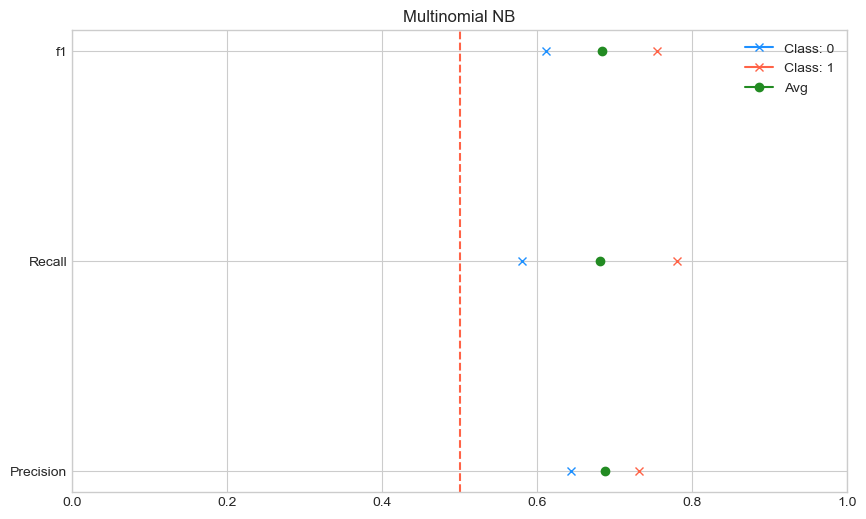

In [103]:
plt.title('Multinomial NB')
plt.axvline(x=.5, color='Tomato', linestyle='--')
pcr(y_test_bin, yhat_nb2_ts)
plt.legend()

* Tiene los indicadores mas altos de los modelos que se han analizado
* con accuracy de .81 en train y .70 en test, no significa un modelo sesgado, pero tampoco es el ideal.

#### 3.1.2 Desempeño

##### 3.1.2.a Desempeño solicitado

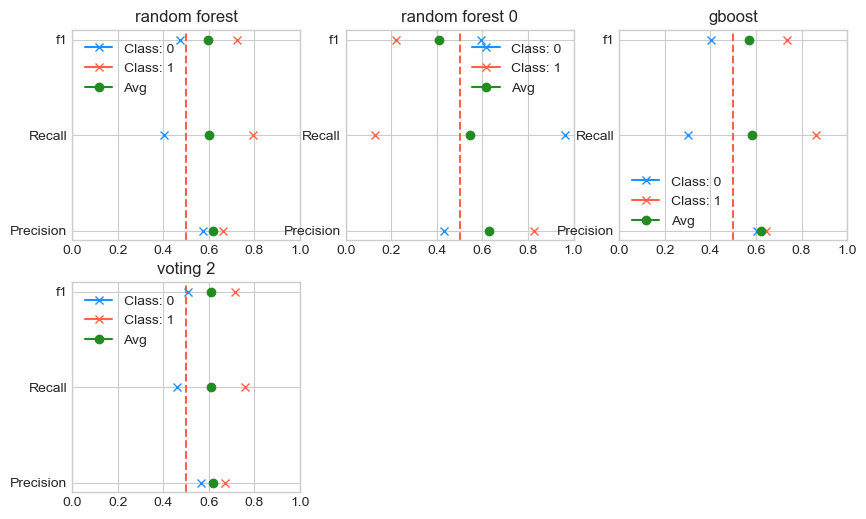

In [104]:
for n, k in enumerate(yhat_modelos):
    value = yhat_modelos[k]
    plt.subplot(2, 3, n + 1)
    plt.title(k)
    plt.axvline(x=.5, color='Tomato', linestyle='--')
    pcr(y_test, value)
    plt.legend()

* Observar como estan de dispersas las clases, siendo random forest y voting los unicos modelos capaces de disminuir esta variabilidad.
* Random forest para la categoria 0 es el único modelo capaz de capturar el comportamiento de la categoria negativa (0), pero tampoco es brillante en esto ya que decae en precision.
* Los dos mejores modelos en cuanto a todos sus indicadores son el random forest balanceado y el voting 2

##### 3.1.2.a - Desempeño modelacion alternativa, propuesta para Voting.

* Entrenar el modelo seleccionado voting con la matiz dodne se eliminaron los neutros a modo de evaluar mejoras en su rendimiento.

Revisar que no se sobre ajusten

In [106]:
Xclear_train, Xclear_test, yclear_train, yclear_test = train_test_split(Xclear_redu,
        yclear_bin,test_size=.33,random_state=1991)

In [113]:
rf_clear = RandomForestClassifier(random_state=1991,  warm_start=True, max_features=None,
                                    criterion='gini', max_depth=100,  min_samples_leaf=0.001, 
                                    min_samples_split=0.001,n_estimators=10 , class_weight={0:1, 1:1})
rf_clear.fit(Xclear_train, yclear_train)
yclearhat_tr_rfcl= rf_clear.predict(Xclear_train)
yclearhat_ts_rfcl= rf_clear.predict(Xclear_test)
print(classification_report(yclear_train, yclearhat_tr_rfcl))
print(classification_report(yclear_test, yclearhat_ts_rfcl))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      8057
           1       0.80      0.76      0.77      7720

    accuracy                           0.79     15777
   macro avg       0.79      0.78      0.78     15777
weighted avg       0.79      0.79      0.79     15777

              precision    recall  f1-score   support

           0       0.65      0.68      0.66      3965
           1       0.65      0.61      0.63      3807

    accuracy                           0.65      7772
   macro avg       0.65      0.65      0.65      7772
weighted avg       0.65      0.65      0.65      7772



* Random fores ligeramente mas debil en detectar la clase positiva.
* Se debilitara la clase negativa para tener un modelo que enfatice la debilidad del rf

In [119]:
rf_clear0 = RandomForestClassifier(random_state=1991,  warm_start=True, max_features=None,
                                    criterion='gini', max_depth=100,  min_samples_leaf=0.001, 
                                    min_samples_split=0.001,n_estimators=10 , class_weight={0:.5, 1:1})
rf_clear0.fit(Xclear_train, yclear_train)
yclearhat_tr_rfcl0= rf_clear0.predict(Xclear_train)
yclearhat_ts_rfcl0= rf_clear0.predict(Xclear_test)
print(classification_report(yclear_train, yclearhat_tr_rfcl0))
print(classification_report(yclear_test, yclearhat_ts_rfcl0))

              precision    recall  f1-score   support

           0       0.88      0.58      0.70      8057
           1       0.67      0.92      0.78      7720

    accuracy                           0.74     15777
   macro avg       0.78      0.75      0.74     15777
weighted avg       0.78      0.74      0.74     15777

              precision    recall  f1-score   support

           0       0.70      0.46      0.56      3965
           1       0.59      0.79      0.67      3807

    accuracy                           0.62      7772
   macro avg       0.64      0.63      0.61      7772
weighted avg       0.64      0.62      0.61      7772



* aumenta la clase positiva y disminuye la negativa junto con el accuracy


In [110]:
gboost_clear = GradientBoostingClassifier()
gboost_clear.fit(Xclear_train, yclear_train)
yclearhat_tr_gboostcl= gboost_clear.predict(Xclear_train)
yclearhat_ts_gboostcl= gboost_clear.predict(Xclear_test)
print(classification_report(yclear_train, yclearhat_tr_gboostcl))
print(classification_report(yclear_test, yclearhat_ts_gboostcl))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71      8057
           1       0.70      0.60      0.65      7720

    accuracy                           0.68     15777
   macro avg       0.69      0.68      0.68     15777
weighted avg       0.68      0.68      0.68     15777

              precision    recall  f1-score   support

           0       0.64      0.74      0.69      3965
           1       0.68      0.57      0.62      3807

    accuracy                           0.66      7772
   macro avg       0.66      0.65      0.65      7772
weighted avg       0.66      0.66      0.65      7772



* Lo modelos muestran tener buena capacidad generalizadora y un accuracy aceptable
* Veamos el modelo de votacion

In [ ]:
estimators_clear = [
    ('rndforest para 1', RandomForestClassifier(random_state=1991,  warm_start=True, max_features=None,
                                    criterion='gini', max_depth=100,  min_samples_leaf=0.001, 
                                    min_samples_split=0.001,n_estimators=10 , class_weight={0:.5, 1:1})), 
    ('rndforest balanceado', RandomForestClassifier(random_state=1991,  warm_start=True, max_features=None,
                                    criterion='gini', max_depth=100,  min_samples_leaf=0.001, 
                                    min_samples_split=0.001,n_estimators=10 , class_weight={0:1, 1:1})),  
    ('gboost', GradientBoostingClassifier())             
]

In [121]:
voting2_clear = VotingClassifier(estimators_clear)
voting2_clear.fit(Xclear_train, yclear_train)
yclearhat_tr_voting2= voting2_clear.predict(Xclear_train)
yclearhat_ts_voting2= voting2_clear.predict(Xclear_test)
print(classification_report(yclear_train, yclearhat_tr_voting2))
print(classification_report(yclear_test, yclearhat_ts_voting2))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      8057
           1       0.74      0.78      0.76      7720

    accuracy                           0.76     15777
   macro avg       0.76      0.76      0.76     15777
weighted avg       0.76      0.76      0.76     15777

              precision    recall  f1-score   support

           0       0.66      0.64      0.65      3965
           1       0.64      0.66      0.65      3807

    accuracy                           0.65      7772
   macro avg       0.65      0.65      0.65      7772
weighted avg       0.65      0.65      0.65      7772



* Se observa buena capacidad generalizacion, solo 11 puntos de diferencia entre train y test.
* Todos los indicadores estables cercanos al .65 indica que el modelo es estable.
* gboost por si solo logra mejor generalizacion y accuracy, voting esta logrando ser mas estable.

Dado de MultinomialNB esta capurando correctamente la clase positiva, evaluemos potenciar un modelo estable para la clase negativa.
* De lo contrario Gboost o voting serian un buen modelo balanceado.

In [122]:
estimators_clear2 = [
    ('rndforest balanceado', RandomForestClassifier(random_state=1991,  warm_start=True, max_features=None,
                                    criterion='gini', max_depth=100,  min_samples_leaf=0.001, 
                                    min_samples_split=0.001,n_estimators=10 , class_weight={0:1, 1:1})),  
    ('gboost', GradientBoostingClassifier())             
]

In [124]:
voting2_clear2 = VotingClassifier(estimators_clear2)
voting2_clear2.fit(Xclear_train, yclear_train)
yclearhat_tr_voting2= voting2_clear2.predict(Xclear_train)
yclearhat_ts_voting2= voting2_clear2.predict(Xclear_test)
print(classification_report(yclear_train, yclearhat_tr_voting2))
print(classification_report(yclear_test, yclearhat_ts_voting2))

              precision    recall  f1-score   support

           0       0.68      0.86      0.76      8057
           1       0.80      0.57      0.67      7720

    accuracy                           0.72     15777
   macro avg       0.74      0.72      0.71     15777
weighted avg       0.74      0.72      0.71     15777

              precision    recall  f1-score   support

           0       0.63      0.80      0.70      3965
           1       0.71      0.51      0.59      3807

    accuracy                           0.66      7772
   macro avg       0.67      0.65      0.65      7772
weighted avg       0.67      0.66      0.65      7772



* Entonces se define el segundo modelo 'Voting2_clear2'

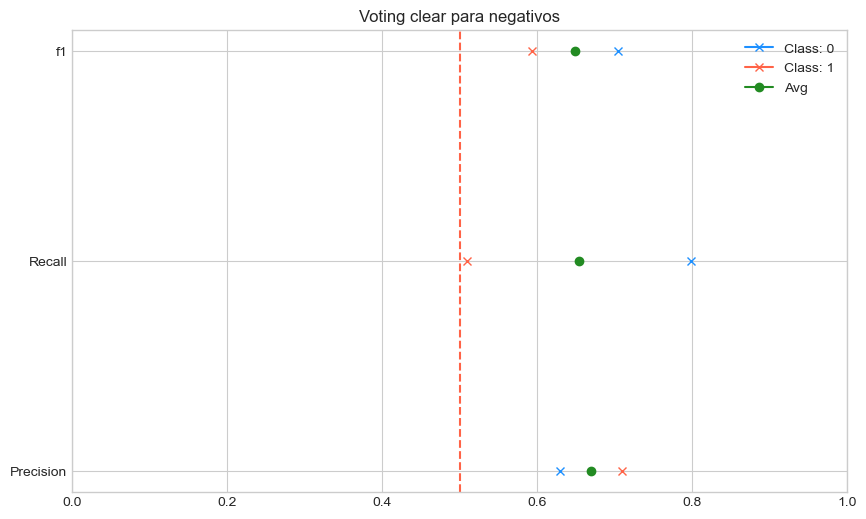

In [126]:
plt.title('Voting clear para negativos')
plt.axvline(x=.5, color='Tomato', linestyle='--')
pcr(yclear_test, yclearhat_ts_voting2)
plt.legend()

##### 3.1.3.a Resultados Generales

In [ ]:

# Matrix Parametros sin neutrales transformado con cv_c
cvclear_fit = cv_c.transform(df_clear['content'])
# Matrix Parametros c con matriz sin neutrales
Xclear_C = cvclear_fit.toarray()
dimred_clear = PCA(n_components = 10,  whiten=True)
project_x = dimred_clear.fit_transform(Xclear_C)
Xclear_redu = pd.DataFrame(project_x)
Xclear_train, Xclear_test, yclear_train, yclear_test = train_test_split(Xclear_redu,
        yclear_bin,test_size=.33,random_state=1991)


Tweets de prueba:

In [128]:
tweet1 = 'I feel bad about the movie, boring from the beginning to the end'
tweet2 = 'the movie was really good, i love the actors performances and the movie effects'
tweet3 = 'happy day mom'
tweet4 = "I hate mother's day"
tweet5 = 'I love star wars'
tweet6 = 'I hate star wars'
# Negativo - Positivo - positivo - negativo - positivo - negativo


**Voting entrenado sin neutrales**

In [131]:
prueba_tweets(tweet1, cv_c, dimred_clear, voting2_clear2) # Negativo 
prueba_tweets(tweet2, cv_c, dimred_clear, voting2_clear2) # Positivo
prueba_tweets(tweet3, cv_c, dimred_clear, voting2_clear2) # positivo 
prueba_tweets(tweet4, cv_c, dimred_clear, voting2_clear2) # negativo 
prueba_tweets(tweet5, cv_c, dimred_clear, voting2_clear2) # positivo
prueba_tweets(tweet6, cv_c, dimred_clear, voting2_clear2) # negativo

Polaridad del tweet:  ['Negativo']
Polaridad del tweet:  ['Positivo']
Polaridad del tweet:  ['Positivo']
Polaridad del tweet:  ['Negativo']
Polaridad del tweet:  ['Positivo']
Polaridad del tweet:  ['Negativo']


* Logra clasificar correctamente frases complejas relacionadas al dataframe en el que se entreno como el dia de la madre y star wars, mencionadas de forma positiva y negativa, tambien categoriza de forma correcta frases genericas.

**NaiveBayes - MultinomialNB

In [134]:
prueba_tweets_nb(tweet1, cv_c_nb, m_nb) # Negativo 
prueba_tweets_nb(tweet2, cv_c_nb, m_nb) # Positivo
prueba_tweets_nb(tweet3, cv_c_nb, m_nb) # positivo 
prueba_tweets_nb(tweet4, cv_c_nb, m_nb) # negativo 
prueba_tweets_nb(tweet5, cv_c_nb, m_nb) # positivo
prueba_tweets_nb(tweet6, cv_c_nb, m_nb) # negativo

Polaridad del tweet:  ['Negativo']
Polaridad del tweet:  ['Positivo']
Polaridad del tweet:  ['Positivo']
Polaridad del tweet:  ['Negativo']
Polaridad del tweet:  ['Positivo']
Polaridad del tweet:  ['Positivo']


* Nive Bayes como se espera no es tan habil en captar los negativos como lo es para los positivos.

* La mayoria de los modelos presentaron problemas para detectar la categoria de negativos (0), en la configuracion solicitada para el entrenamiento.
* Como investigador y dada las pruebas realizadas a lo largo del ejercicio noté que la codificacion solicitada de manera a aleatoria solo genera ruido en los datos, ya que los modelos se vieron beneficiados de quitar los elementos neutrales asignados de manera aleatoria en sus categorias. Si bien SVC no mostro ser un buen modelo al incluir la clase neutral, al sacar estos elementos de la muestra y entrenamiento el modelo logra separar mejor las categorias positivas y negativas, incluso siendo mas habiles en clasificar los negativos.
* Finalmente ambos modelos demostraron se capaces de predecir los tweets como se espera uno para positivos y otro para negativos, el que mejor se comporta es es voting.

##### 3.1.3.b Conclusiones

* Voting se beneficia de los modelos que son capaces de predecir categorias especificas, como el random forest creado para captar la categoria negativa.
* Random forest logra resultados muy buenos, y es muy versatil en su configuración, pero se sobre ajusta demasiado.
* Los modelos SVM utilizan muchos recursos computacionales, y para un PC domestico es dificil de calibrar sus grillas.
* Las clasificaciones aleatorias de datos complican mas los problemas, aislar estas clases parece ser mejor solución.

##### 3.1.3.c - Modelo Seleccionado

* Si lo que se busca es ser certero en los positivos se recomienda utilizar  el modelo **m_nb** basado en multinomial NB parametrizado
* Si lo que se busca es ser certero en los neativos  se remocienda utilizar el modelo **voting2_clear2** basado en un sistema de votacion compuesto por random forest y gradient boost.
* El segundo modelo tambien se puede preparar para clasificar ambas clases con 65 de accuracy y ser mas equilibrado.

### 3.2 Serialización

#### Serialización de modelos

* Se serializan los dos mejores modelos en archivos adjuntos en el entregable.
    - Voting con distibucion de pesos w1 entrenado con neutrales asignados aleatoriamente
    - Voting con distibucion de pesos w1 quitando los valores neutrales del Data Frame de entrenamiento

In [135]:
dump(m_nb,open('diego_lizana_m_nb.sav', 'wb'))
dump(voting2_clear2,open('diego_lizana_voting2_clear2.sav', 'wb'))

# **FIN**